## Computation of trial-to-trial correlation and related plots
The two trial_correlate functions are nearly identical but the second one excludes the 7 discarded trials (for complex tones only)

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.preprocessing import StandardScaler
import os
import seaborn as sns 

from preprocessing_final import preprocessing, reverse_preprocessing_img, generate_masks, cv_split_LOO, select_stimulus_subset, preprocessing_pure, cv_split_trial, cv_split_newstim
from audio_processing_final import create_spectrograms, plot_spectrogram
from bandpass_filter_final import lowhigh_normalize

In [13]:
def trial_correlate(dataset, subset=None,
                    relevance_cutoff=0.25,
                    ds=4, 
                    input_seconds=0.3, 
                    delay=0, 
                    reverse_direction=False,
                    single_input=False):
    """" Returns average (across pixels) trial-to-trial (ttt) correlation, list of stimuli for reference,
    and average ttt correlations for each trial.
    Function is identical to preprocessing initially in creating the datasets
    
    """
    # Create datasets
    spectrograms = create_spectrograms(FFT_overlap=0, plot=False, scaling="decibels")
    tseries = []
    stimuli = []
    numTrials = 0
    if "pure" in dataset:
        tseries.extend([f"tseries_{i}" for i in [28, 33, 34, 39]])
        stimulus = np.load("auditorycoding/F189/tseries_28/stimulus.npy")
        stim_set = set([s[0] + 203 for s in stimulus])
        if single_input == False:
            stim_set.difference_update({213, 214, 215})
        stimuli.extend(stim_set)
        numTrials += 32
    if "complex_full" in dataset:
        tseries.extend([f"tseries_{i}" for i in [21, 24, 27, 31, 36, 38]])
        stimulus = np.load("auditorycoding/F189/tseries_21/stimulus.npy")
        stimuli.extend(set([s[0] for s in stimulus]))
    if  "complex_sub" in dataset:
        tseries.extend([f"tseries_{i}" for i in [23, 26, 29, 32, 37]])
        stimulus = np.load("auditorycoding/F189/tseries_23/stimulus.npy")
        stimuli.extend(set([s[0] for s in stimulus]))
        numTrials += 15
    if "mov" in dataset:
        tseries.extend([f"tseries_{i}" for i in [25, 30]])
        # ???? TBD
        stimulus = np.load("auditorycoding/F189/tseries_28/stimulus.npy")
        stimuli.extend([s[0] + 203 for s in stimulus])
    
    if single_input == True:
        X_cut, Y_cut, ft_cut, frame_idx_cut, frame_trial_idx_cut = preprocessing_pure(tseries[0],
        relevance_cutoff=relevance_cutoff, ds=ds, delay=delay, mode="filtered")[2:]

        for series in tseries[1:]:
            Xi_cut, Yi_cut, fti_cut, framei_idx_cut, framei_trial_idx_cut = preprocessing_pure(series,
            relevance_cutoff=relevance_cutoff, ds=ds, delay=delay, mode="filtered")[2:]
            X_cut = np.vstack((X_cut, Xi_cut))
            Y_cut = np.vstack((Y_cut, Yi_cut))
            frame_idx_cut = np.append(frame_idx_cut, framei_idx_cut)
            frame_trial_idx_cut = np.append(frame_trial_idx_cut, framei_trial_idx_cut + frame_trial_idx_cut.max())

    elif single_input == False:
        X_cut, Y_cut, ft_cut, frame_idx_cut, frame_trial_idx_cut = preprocessing(tseries[0], spectrograms=spectrograms,
        relevance_cutoff=relevance_cutoff, input_seconds=input_seconds, ds=ds, delay=delay, mode="filtered")[2:]

        for series in tseries[1:]:
            Xi_cut, Yi_cut, fti_cut, framei_idx_cut, framei_trial_idx_cut = preprocessing(series, spectrograms=spectrograms,
            relevance_cutoff=relevance_cutoff, input_seconds=input_seconds, ds=ds, delay=delay, mode="filtered")[2:]
            X_cut = np.vstack((X_cut, Xi_cut))
            Y_cut = np.vstack((Y_cut, Yi_cut))
            frame_idx_cut = np.append(frame_idx_cut, framei_idx_cut)
            frame_trial_idx_cut = np.append(frame_trial_idx_cut, framei_trial_idx_cut + frame_trial_idx_cut.max())

    print(X_cut.shape, Y_cut.shape)
    if subset:
        X_cut, Y_cut, frame_idx_cut, frame_trial_idx_cut = select_stimulus_subset(X_cut, 
                                                                                  Y_cut, 
                                                                                  frame_idx_cut, 
                                                                                  frame_trial_idx_cut, 
                                                                                  subset)
    
    # Isolate stimuli in each trial and correlate them.
    mean_correlations = []
    stims = []
    trial_means = np.zeros((numTrials,len(np.unique(frame_idx_cut))))
    # Iterate over all stimuli
    for s, stim in enumerate(np.unique(frame_idx_cut)):
        stim_idx = np.where(frame_idx_cut == stim)[0]

        test_trial_index = frame_trial_idx_cut[stim_idx]
        x_test = X_cut[stim_idx]
        y_test = Y_cut[stim_idx]

        len_per_trial = [len(np.where(test_trial_index == k)[0]) for k in set(test_trial_index)]
        #print(len_per_trial)

        reference_trial = 2
        reference_condition = np.where(test_trial_index == reference_trial)[0]
        # reverse_direction should always be False to correlate widefield images
        if reverse_direction == False:
            # Differentiate b/w complex and pure data since np.unique() is required
            # on complex but does not make sense on pure
            if dataset == "complex_sub":
                x_len = np.unique(x_test[reference_condition,:], axis=0)
                y_len = y_test[reference_condition,:]
                x_new = np.zeros(shape=(numTrials, x_len.shape[0], x_len.shape[1]))
                y_new = np.zeros(shape=(numTrials, x_len.shape[0], y_len.shape[1]))               

            elif dataset == "pure":
                x_len = x_test[reference_condition,:]
                y_len = y_test[reference_condition,:]
                if single_input:
                    x_len = x_test[reference_condition]
                x_new = np.zeros(shape=(numTrials, 12, x_len.shape[1]))
                y_new = np.zeros(shape=(numTrials, 12, y_len.shape[1]))             


            if single_input:
                x_new = np.zeros(shape=(numTrials, x_len.shape[0]))
            
            # isolate stimulus in each trial
            for t, trial_number in enumerate(range(1, numTrials + 1)):
                x_temp = x_test[np.where(test_trial_index == trial_number)[0],:]
                y_temp = y_test[np.where(test_trial_index == trial_number)[0],:]
                if single_input:
                    x_temp = x_test[np.where(test_trial_index == trial_number)[0]]
                if dataset == "complex_sub":
                    _, unique_idx = np.unique(x_temp, return_index=True, axis=0)
                    uniquey = np.unique(y_temp, axis=0)
                    #print("unique X",_.shape)
                    #print("unique Y",uniquey.shape)
                    x_new[int(trial_number-1),:,:] = x_temp[unique_idx,:]
                    y_new[int(trial_number-1),:,:] = y_temp[unique_idx,:]
                elif dataset == "pure":
                    x_new[int(trial_number-1),:,:] = x_temp[:x_new.shape[1],:]
                    y_new[int(trial_number-1),:,:] = y_temp[:y_new.shape[1],:]
        
        
        # Correlate stimulus across all trials
        stim_corr = np.corrcoef(y_new.reshape((y_new.shape[0], y_new.shape[1] * y_new.shape[2])))
        weights = np.ones((numTrials,numTrials)) - np.diag(np.ones(numTrials))
        stim_corr_mean = np.average(stim_corr, weights=weights)
        mean_correlations.append(stim_corr_mean)
        stims.append(stim)
        trial_means[:,s] = np.mean(stim_corr, axis=0)
        
        # Plot the Mean activity with correlation
        fig, ax = plt.subplots(1,1,figsize=(20,10))
        im = ax.imshow(reverse_preprocessing_img(np.array([np.mean(y_new, axis=(0,1)),np.mean(y_new, axis=(0,1))]), relevance_cutoff=0.25, ds=4)[0], cmap="binary")
        ax.tick_params(axis='both', which='both', left=False,bottom=False,labelbottom=False,labelleft=False,labelsize=13)
        ax.set_title(f"Stimulus: {stim}; Correlation: {round(stim_corr_mean,2)}", fontsize=40)        
        cbar = fig.colorbar(im,fraction=0.04, pad=0.04)
        cbar.ax.tick_params(labelsize=35)  
        cbar.set_label('Mean activity', rotation=270, fontsize=50, labelpad=50)
        fig.savefig(f"Document Plots/stimActivity/stim{stim}.png") 
        plt.show()

        print(y_new.shape)

    return mean_correlations, stims, trial_means



100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:25<00:00,  7.91it/s]


(3535, 532) (3535, 3072)
(0,)
204.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 85306.04it/s]


(2, 5360) (5360,)


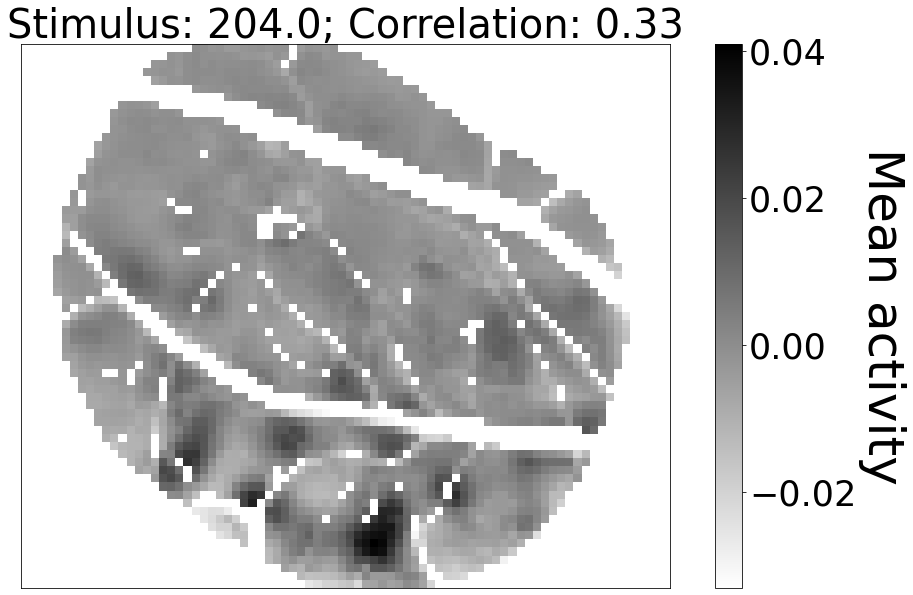

(32, 12, 3072)
(0,)
205.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 68469.67it/s]


(2, 5360) (5360,)


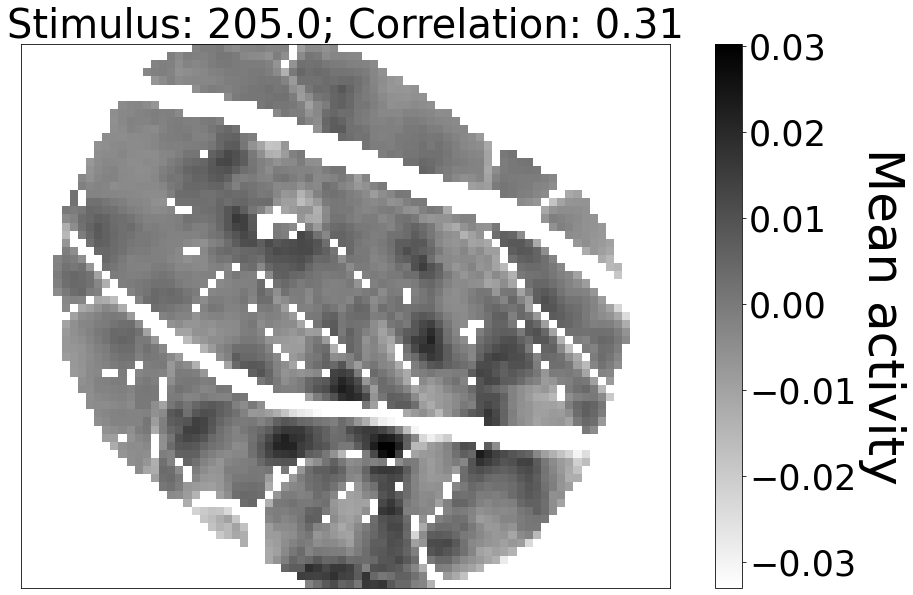

(32, 12, 3072)
(0,)
206.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 63976.50it/s]


(2, 5360) (5360,)


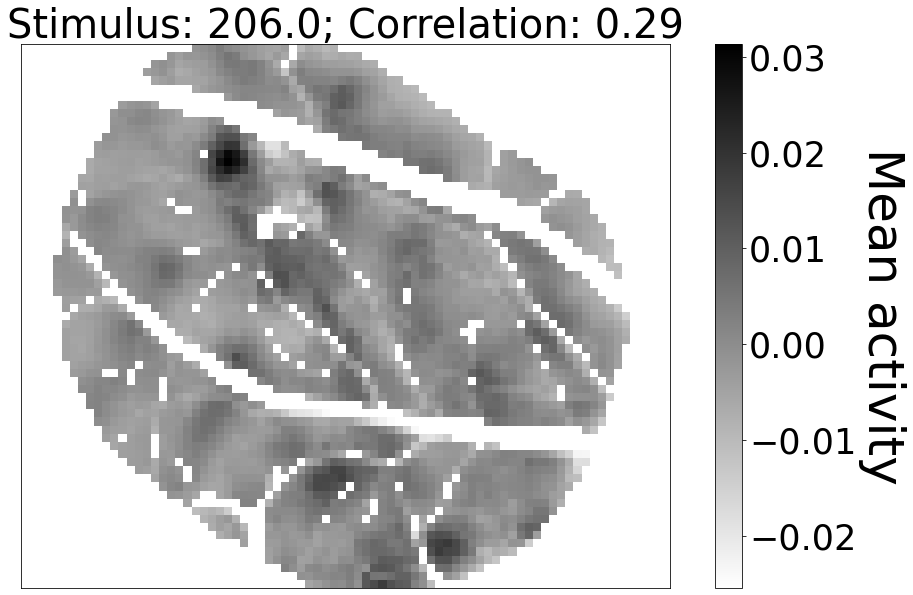

(32, 12, 3072)
(0,)
207.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 73624.77it/s]


(2, 5360) (5360,)


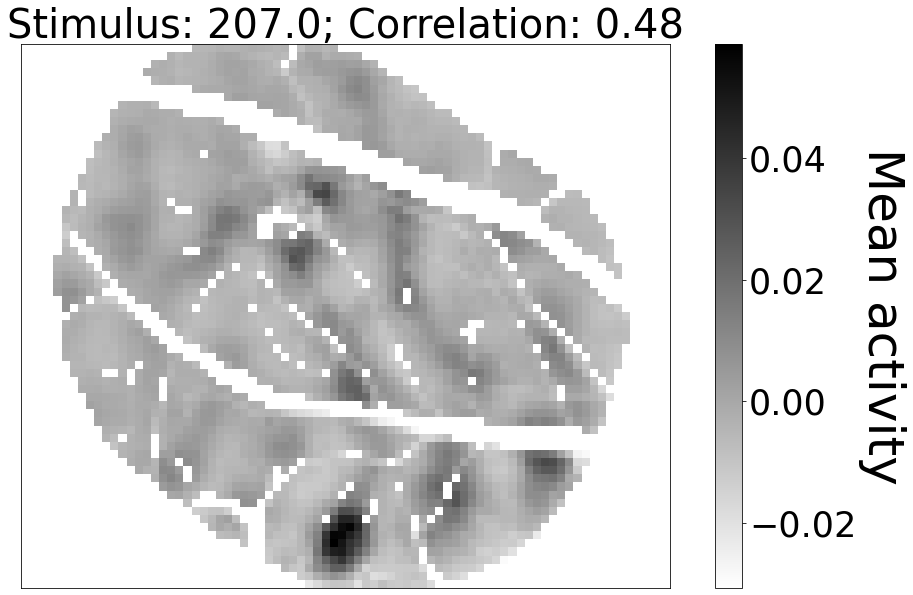

(32, 12, 3072)
(0,)
208.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83974.75it/s]


(2, 5360) (5360,)


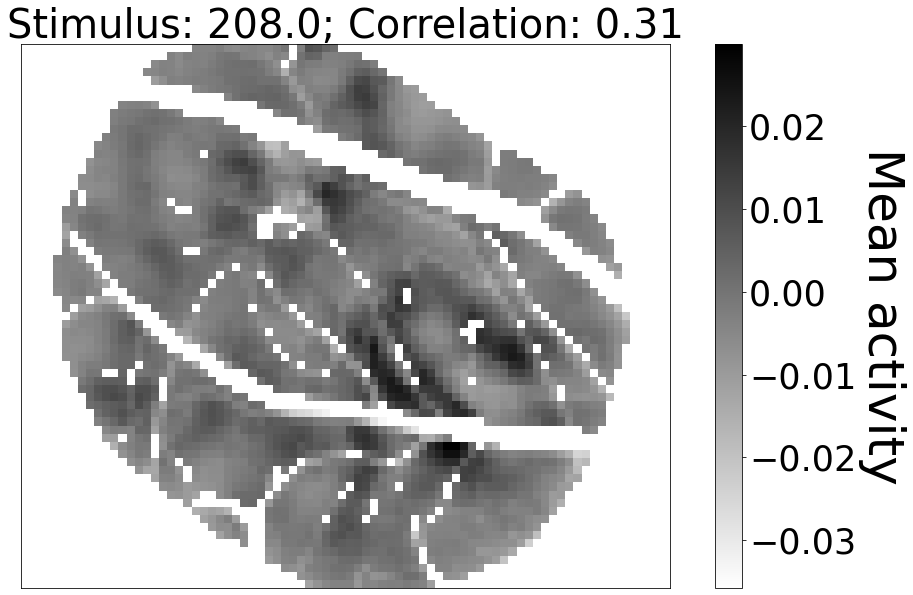

(32, 12, 3072)
(0,)
209.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 88079.04it/s]


(2, 5360) (5360,)


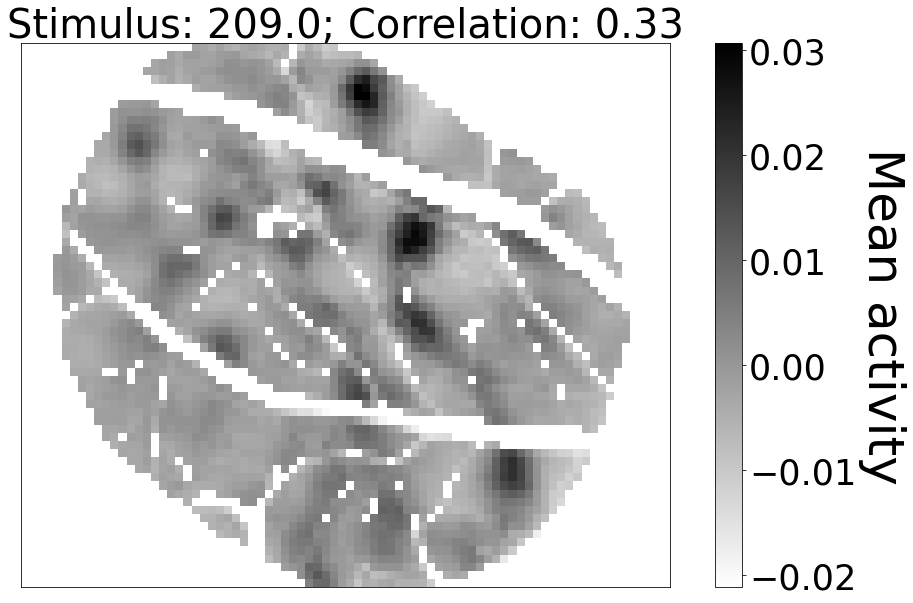

(32, 12, 3072)
(0,)
210.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 92656.27it/s]


(2, 5360) (5360,)


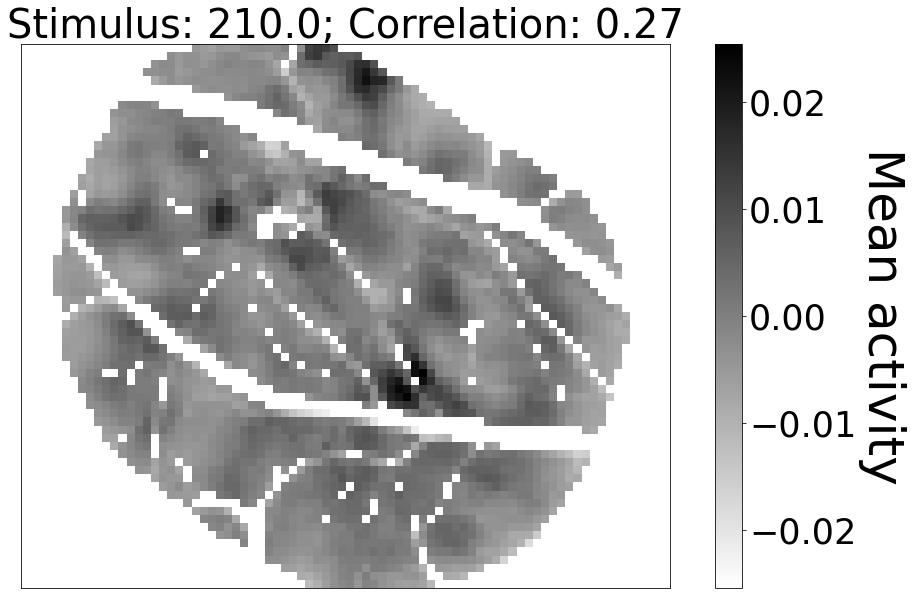

(32, 12, 3072)
(0,)
211.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 92665.06it/s]


(2, 5360) (5360,)


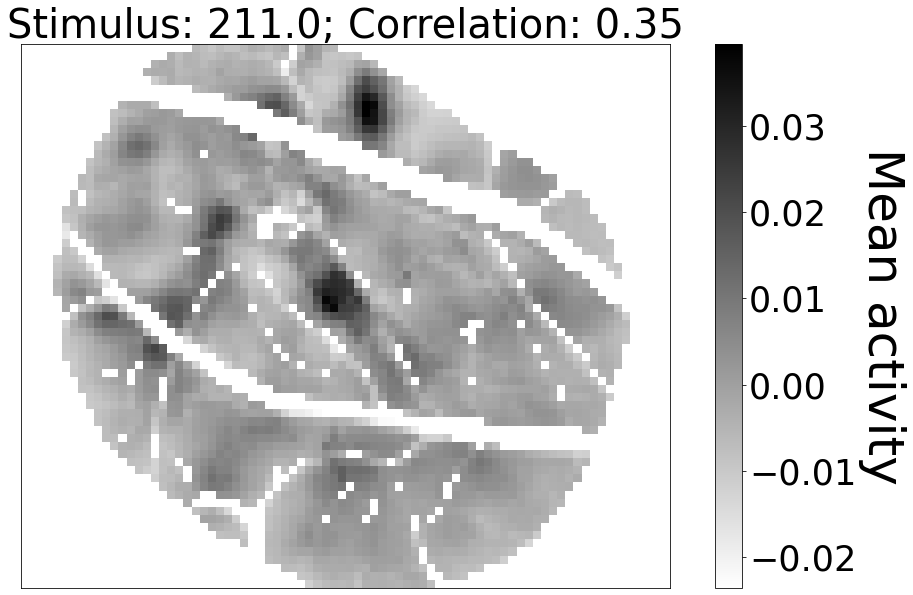

(32, 12, 3072)
(0,)
212.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 89527.30it/s]


(2, 5360) (5360,)


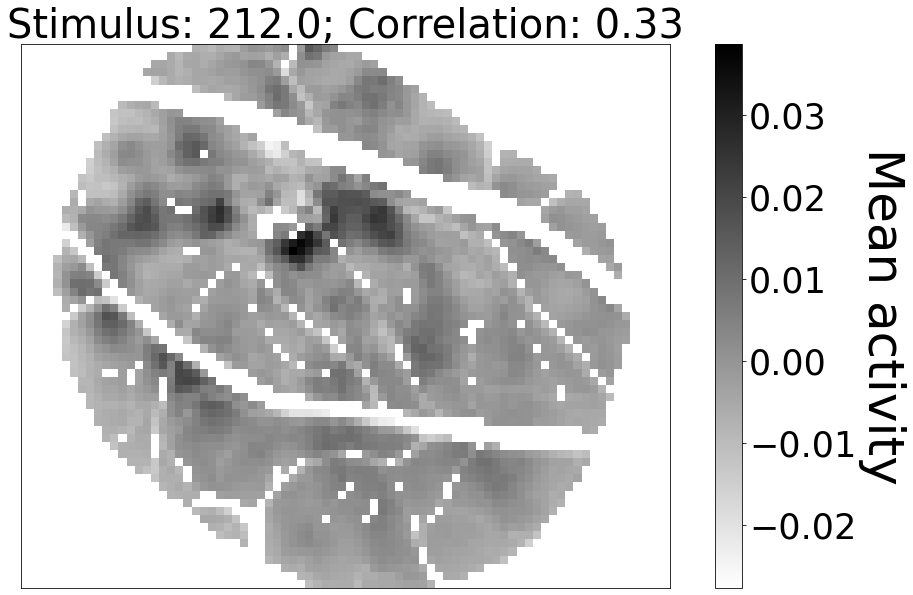

(32, 12, 3072)


In [14]:
corr, stims, trial_means = trial_correlate("pure", None, single_input=False)

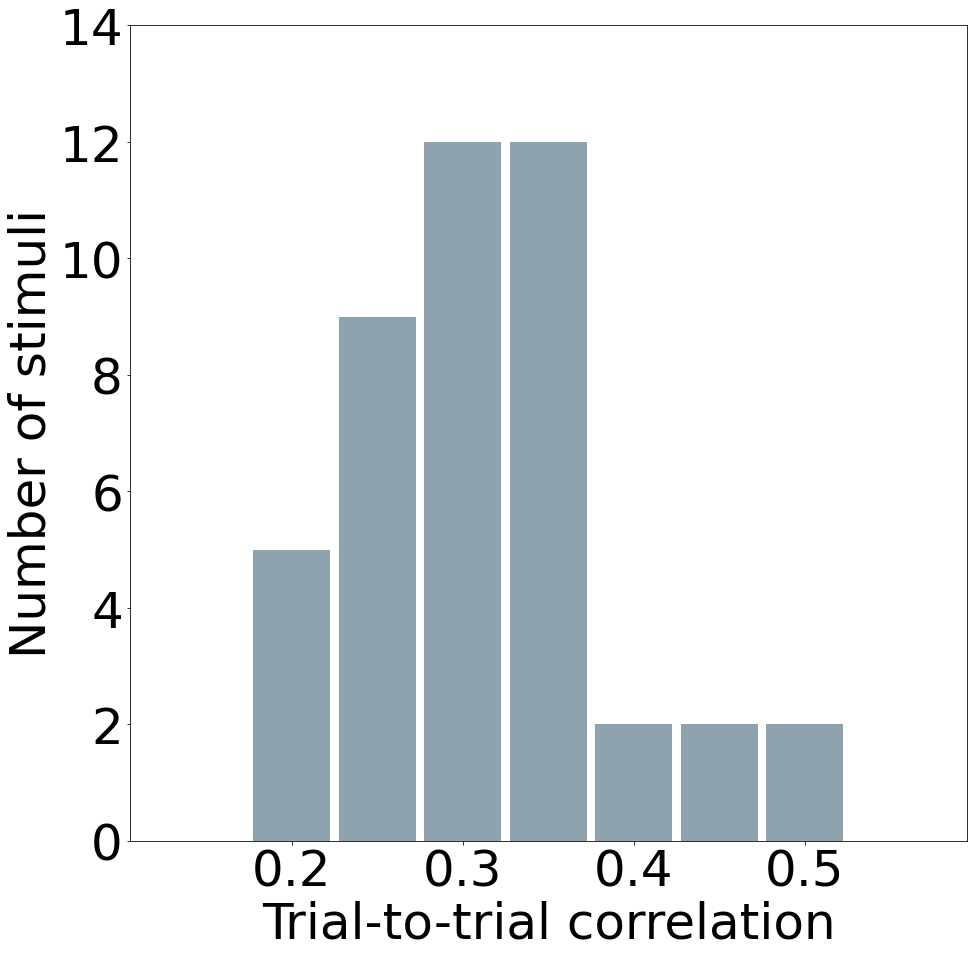

In [5]:
# Histogram of the correlations
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.hist(corr, bins=np.arange(0.15,0.65,0.05)-0.025, color='#607c8e', alpha=0.7,  rwidth=0.9)
ax.set_ylim([0,14])                   
ax.set_xlabel("Trial-to-trial correlation", fontsize=50)
ax.set_ylabel("Number of stimuli", fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.show()
#fig.savefig("Document Plots/ttt_correlations_15trials.png")

In [11]:
def trial_correlate_2(dataset, subset=None,
                    relevance_cutoff=0.25,
                    ds=4, 
                    input_seconds=0.3, 
                    delay=0, 
                    reverse_direction=False,
                    single_input=False):
    """Same as previous function but defective trials are excluded. 
    Use only for complex data."""
    spectrograms = create_spectrograms(FFT_overlap=0, plot=False, scaling="decibels")
    tseries = []
    stimuli = []
    numTrials = 0
    if "pure" in dataset:
        tseries.extend([f"tseries_{i}" for i in [28, 33, 34, 39]])
        stimulus = np.load("auditorycoding/F189/tseries_28/stimulus.npy")
        stim_set = set([s[0] + 203 for s in stimulus])
        if single_input == False:
            stim_set.difference_update({213, 214, 215})
        stimuli.extend(stim_set)
        numTrials += 32
    if "complex_full" in dataset:
        tseries.extend([f"tseries_{i}" for i in [21, 24, 27, 31, 36, 38]])
        stimulus = np.load("auditorycoding/F189/tseries_21/stimulus.npy")
        stimuli.extend(set([s[0] for s in stimulus]))
    if  "complex_sub" in dataset:
        tseries.extend([f"tseries_{i}" for i in [23, 26, 29, 32, 37]])
        stimulus = np.load("auditorycoding/F189/tseries_23/stimulus.npy")
        stimuli.extend(set([s[0] for s in stimulus]))
        numTrials += (15 - 7)
    if "mov" in dataset:
        tseries.extend([f"tseries_{i}" for i in [25, 30]])
        # ???? TBD
        stimulus = np.load("auditorycoding/F189/tseries_28/stimulus.npy")
        stimuli.extend([s[0] + 203 for s in stimulus])
    
    if single_input == True:
        X_cut, Y_cut, ft_cut, frame_idx_cut, frame_trial_idx_cut = preprocessing_pure(tseries[0],
        relevance_cutoff=relevance_cutoff, ds=ds, delay=delay, mode="filtered")[2:]

        for series in tseries[1:]:
            Xi_cut, Yi_cut, fti_cut, framei_idx_cut, framei_trial_idx_cut = preprocessing_pure(series,
            relevance_cutoff=relevance_cutoff, ds=ds, delay=delay, mode="filtered")[2:]
            X_cut = np.vstack((X_cut, Xi_cut))
            Y_cut = np.vstack((Y_cut, Yi_cut))
            frame_idx_cut = np.append(frame_idx_cut, framei_idx_cut)
            frame_trial_idx_cut = np.append(frame_trial_idx_cut, framei_trial_idx_cut + frame_trial_idx_cut.max())

    elif single_input == False:
        X_cut, Y_cut, ft_cut, frame_idx_cut, frame_trial_idx_cut = preprocessing(tseries[0], spectrograms=spectrograms,
        relevance_cutoff=relevance_cutoff, input_seconds=input_seconds, ds=ds, delay=delay, mode="filtered")[2:]

        for series in tseries[1:]:
            Xi_cut, Yi_cut, fti_cut, framei_idx_cut, framei_trial_idx_cut = preprocessing(series, spectrograms=spectrograms,
            relevance_cutoff=relevance_cutoff, input_seconds=input_seconds, ds=ds, delay=delay, mode="filtered")[2:]
            X_cut = np.vstack((X_cut, Xi_cut))
            Y_cut = np.vstack((Y_cut, Yi_cut))
            frame_idx_cut = np.append(frame_idx_cut, framei_idx_cut)
            frame_trial_idx_cut = np.append(frame_trial_idx_cut, framei_trial_idx_cut + frame_trial_idx_cut.max())

        
    if subset:
        X_cut, Y_cut, frame_idx_cut, frame_trial_idx_cut = select_stimulus_subset(X_cut, 
                                                                                  Y_cut, 
                                                                                  frame_idx_cut, 
                                                                                  frame_trial_idx_cut, 
                                                                                  subset)
        
    # Here the exclusion is executed    
    if "complex_sub" in dataset:
        invalid_trials = [1,2,7,9,11,13,15]
        valid_trials = set(frame_trial_idx_cut).difference(invalid_trials)
        valid_idx = [a for a in range(len(frame_trial_idx_cut))
                     if any(frame_trial_idx_cut[a] == b for b in valid_trials)]
        X_cut = X_cut[valid_idx,:]
        Y_cut = Y_cut[valid_idx,:]
        frame_idx_cut = frame_idx_cut[valid_idx]
        frame_trial_idx_cut = frame_trial_idx_cut[valid_idx]
        
    mean_correlations = []
    stims = []
    trial_means = np.zeros((numTrials,len(np.unique(frame_idx_cut))))
    for s, stim in enumerate(np.unique(frame_idx_cut)):
        stim_idx = np.where(frame_idx_cut == stim)[0]

        test_trial_index = frame_trial_idx_cut[stim_idx]
        x_test = X_cut[stim_idx]
        y_test = Y_cut[stim_idx]

        len_per_trial = [len(np.where(test_trial_index == k)[0]) for k in set(test_trial_index)]

        reference_trial = 3
        reference_condition = np.where(test_trial_index == reference_trial)[0]
        if reverse_direction == False:
            x_len = np.unique(x_test[reference_condition,:], axis=0)
            y_len = y_test[reference_condition,:]

            x_new = np.zeros(shape=(numTrials, x_len.shape[0], x_len.shape[1]))
            y_new = np.zeros(shape=(numTrials, x_len.shape[0], y_len.shape[1]))

            for t, trial_number in enumerate(valid_trials):
                x_temp = x_test[np.where(test_trial_index == trial_number)[0],:]
                y_temp = y_test[np.where(test_trial_index == trial_number)[0],:]

                _, unique_idx = np.unique(x_temp, return_index=True, axis=0)
                uniquey = np.unique(y_temp, axis=0)

                x_new[int(t),:,:] = x_temp[unique_idx,:]
                y_new[int(t),:,:] = y_temp[unique_idx,:]
                
        stim_corr = np.corrcoef(y_new.reshape((y_new.shape[0], y_new.shape[1] * y_new.shape[2])))
        weights = np.ones((numTrials,numTrials)) - np.diag(np.ones(numTrials))
        stim_corr_mean = np.average(stim_corr, weights=weights)
        mean_correlations.append(stim_corr_mean)
        stims.append(stim)

        trial_means[:,s] = np.mean(stim_corr, axis=0)

        fig, ax = plt.subplots(1,1,figsize=(20,10))
        im = ax.imshow(reverse_preprocessing_img(np.array([np.mean(y_new, axis=(0,1)),np.mean(y_new, axis=(0,1))]), relevance_cutoff=0.25, ds=4)[0], cmap="binary")
        ax.tick_params(axis='both', which='both', left=False,bottom=False,labelbottom=False,labelleft=False,labelsize=13)
        ax.set_title(f"Stimulus: {stim}; Correlation: {round(stim_corr_mean,2)}", fontsize=40)        

        cbar = fig.colorbar(im,fraction=0.04, pad=0.04)
        cbar.ax.tick_params(labelsize=35)  
        cbar.set_label('Mean activity', rotation=270, fontsize=50, labelpad=50)
        fig.savefig(f"Document Plots/stimActivity/stim{stim}.png") 
        plt.show()

    return mean_correlations, stims, trial_means



100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:24<00:00,  8.32it/s]


1.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 85311.87it/s]


(2, 5360) (5360,)


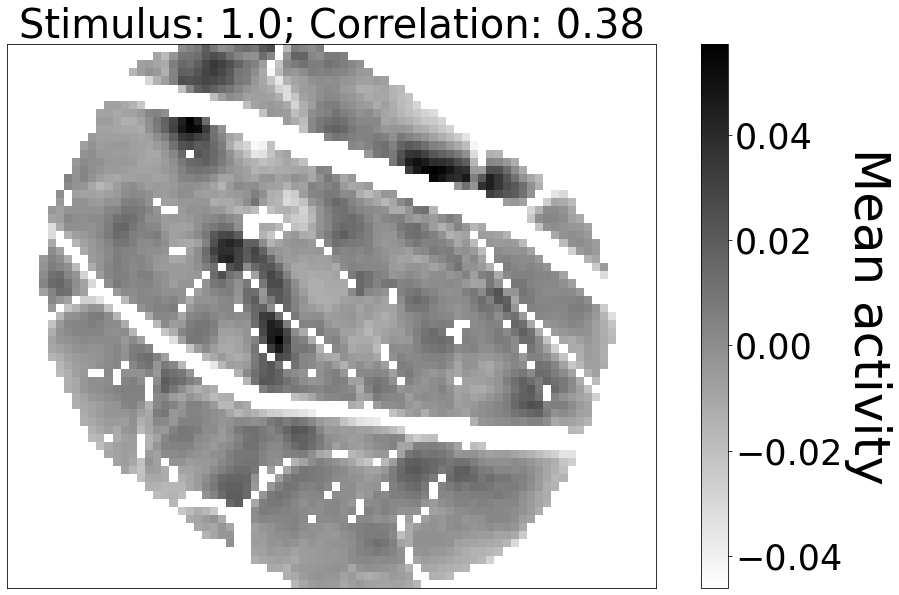

12.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 74643.89it/s]


(2, 5360) (5360,)


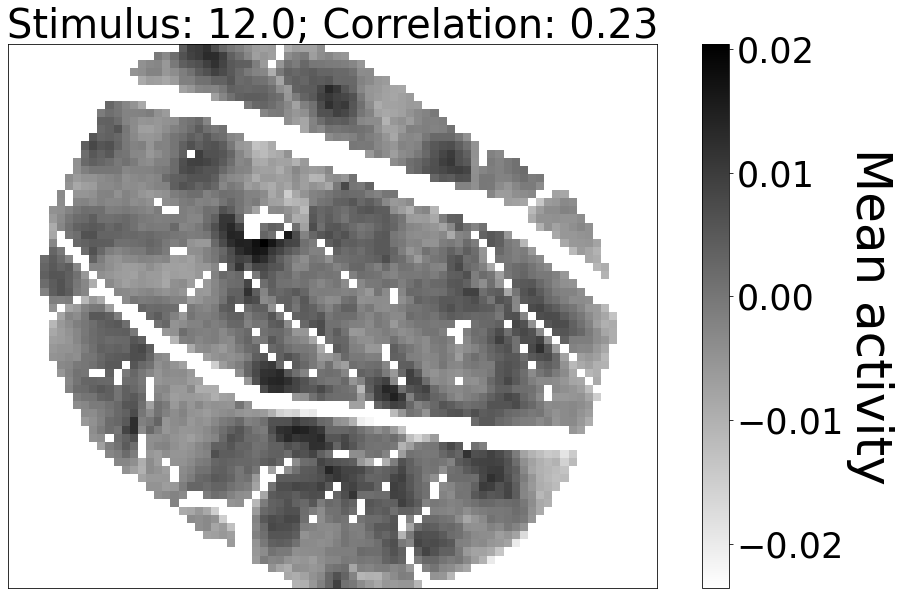

25.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83956.25it/s]


(2, 5360) (5360,)


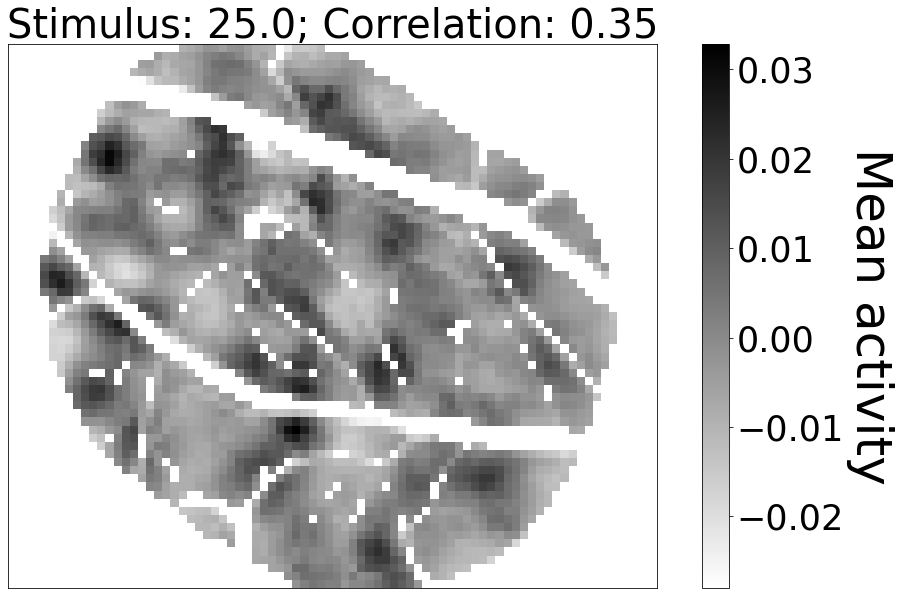

44.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 79003.49it/s]


(2, 5360) (5360,)


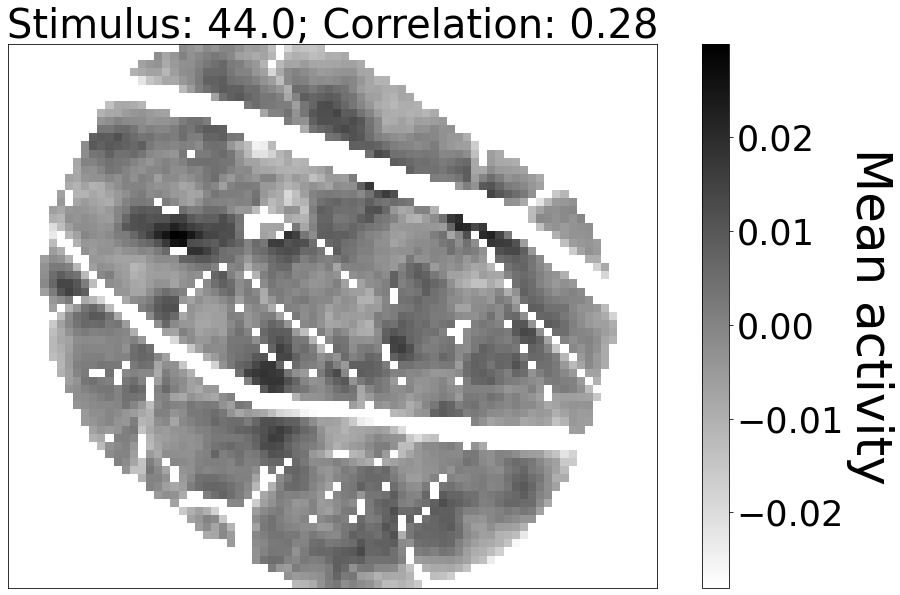

51.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82647.90it/s]


(2, 5360) (5360,)


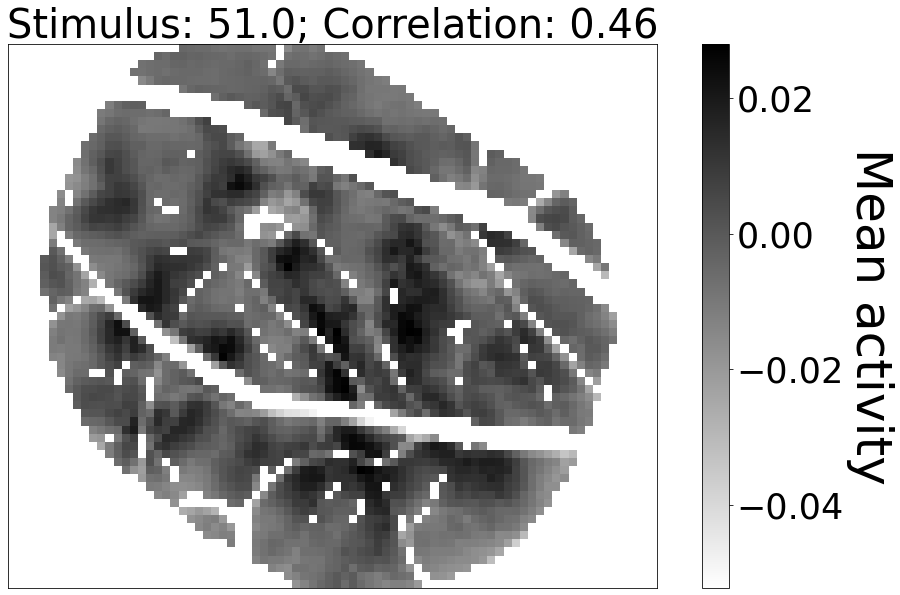

53.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 78325.82it/s]


(2, 5360) (5360,)


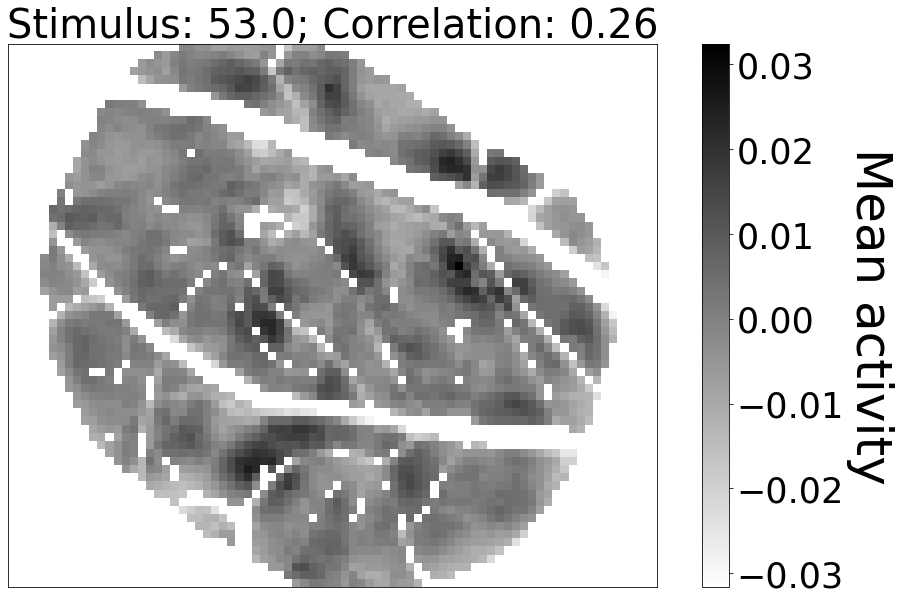

56.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83955.63it/s]


(2, 5360) (5360,)


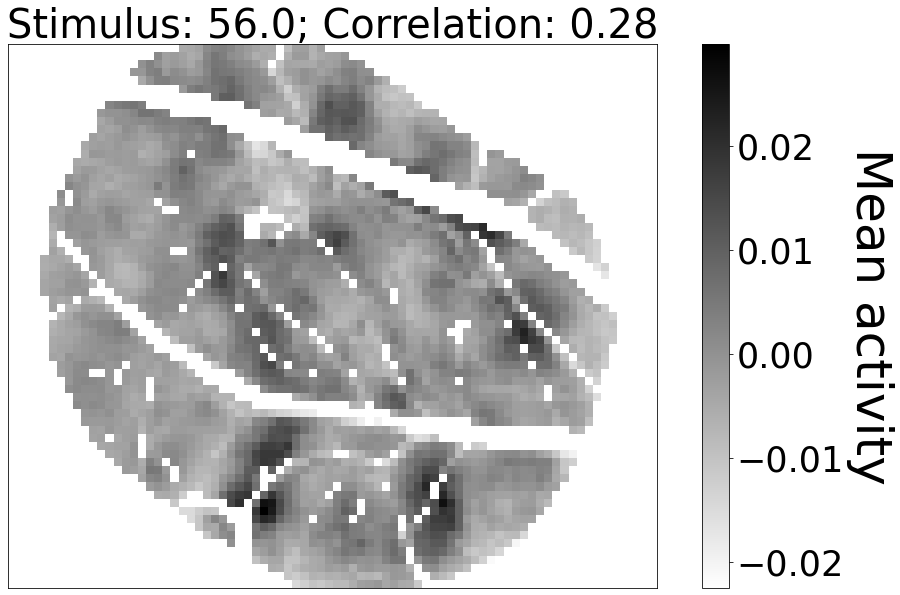

57.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 80231.08it/s]


(2, 5360) (5360,)


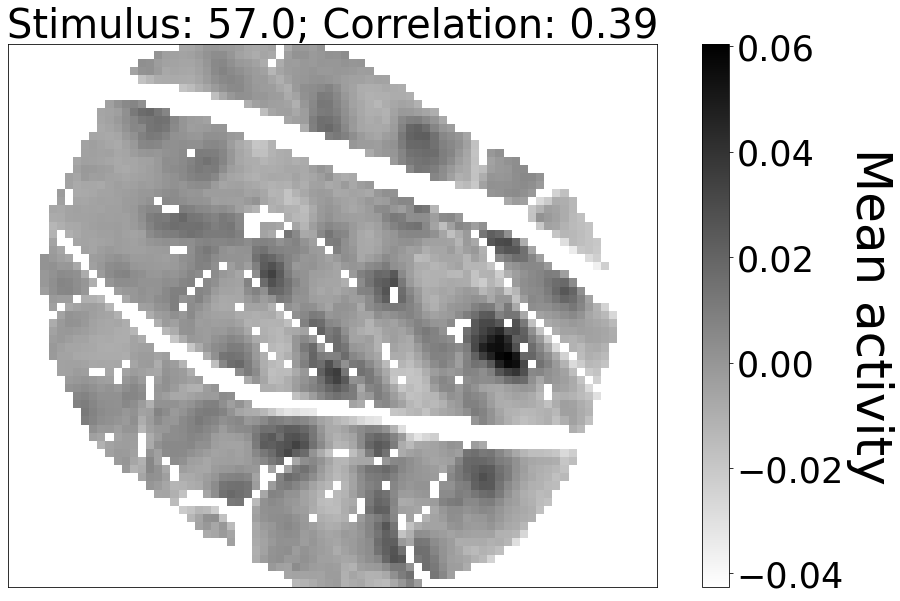

63.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 68020.13it/s]


(2, 5360) (5360,)


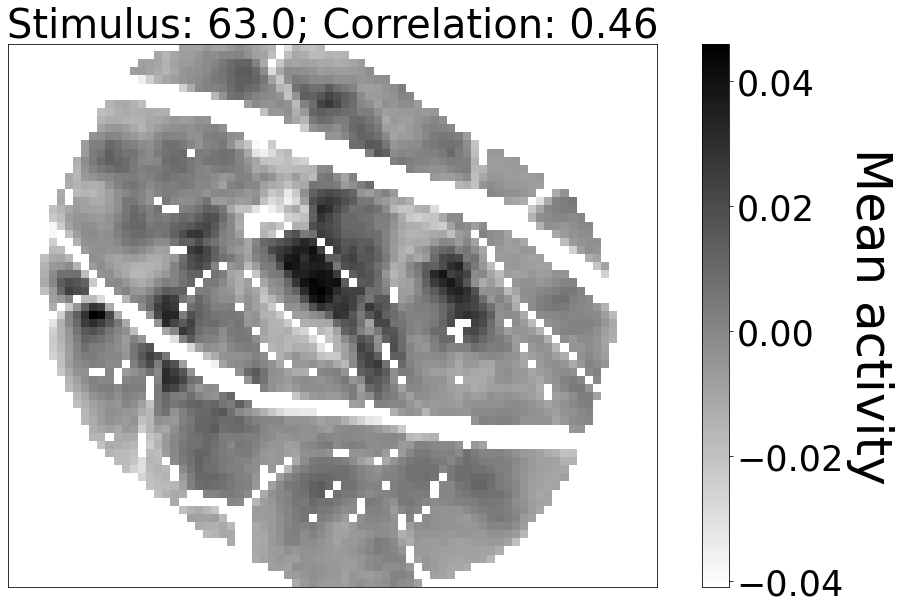

68.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83331.98it/s]


(2, 5360) (5360,)


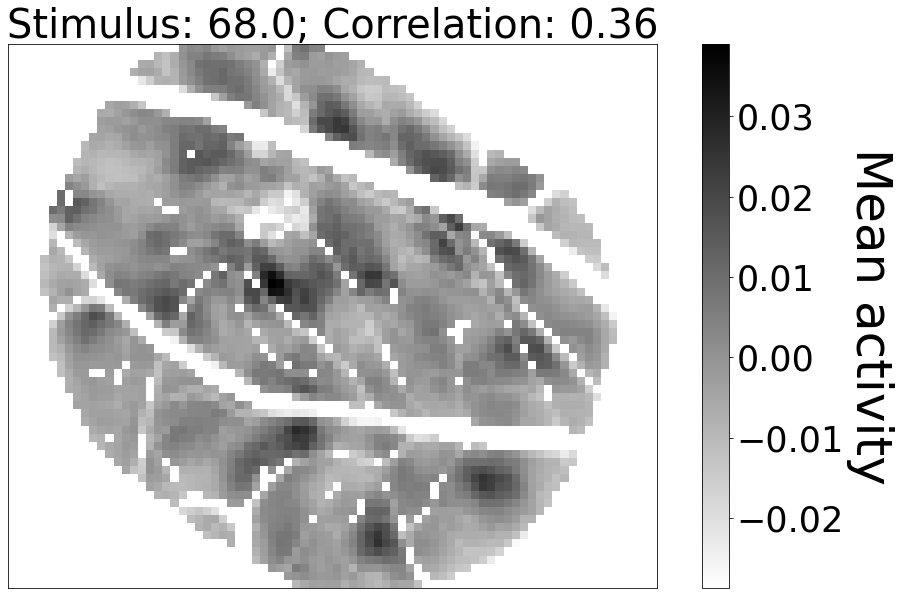

72.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 80182.14it/s]


(2, 5360) (5360,)


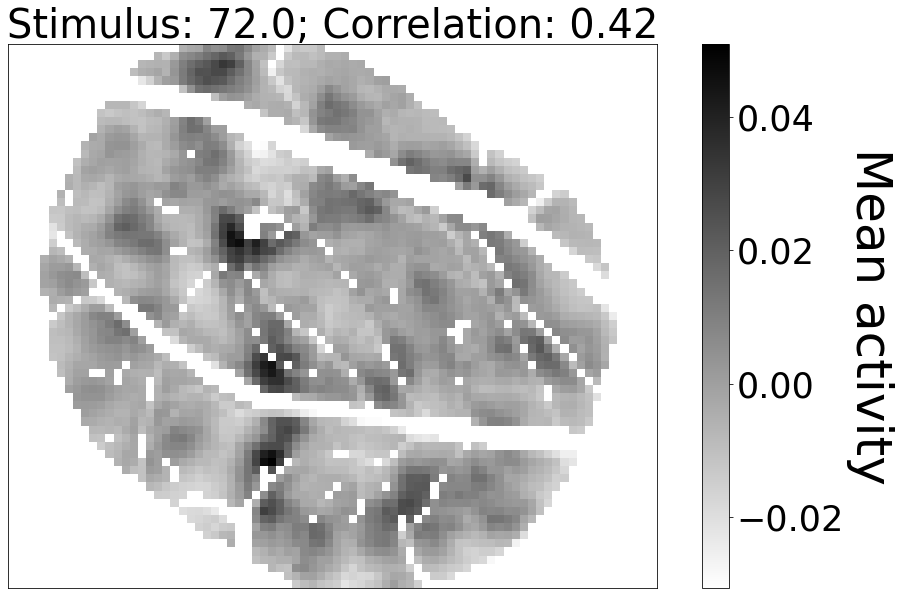

73.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 77847.39it/s]


(2, 5360) (5360,)


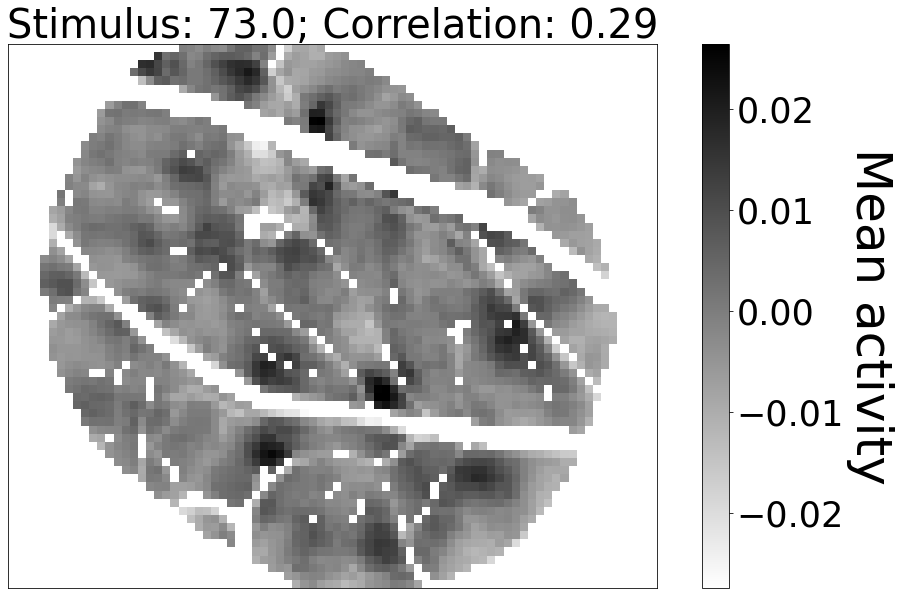

79.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 75693.14it/s]


(2, 5360) (5360,)


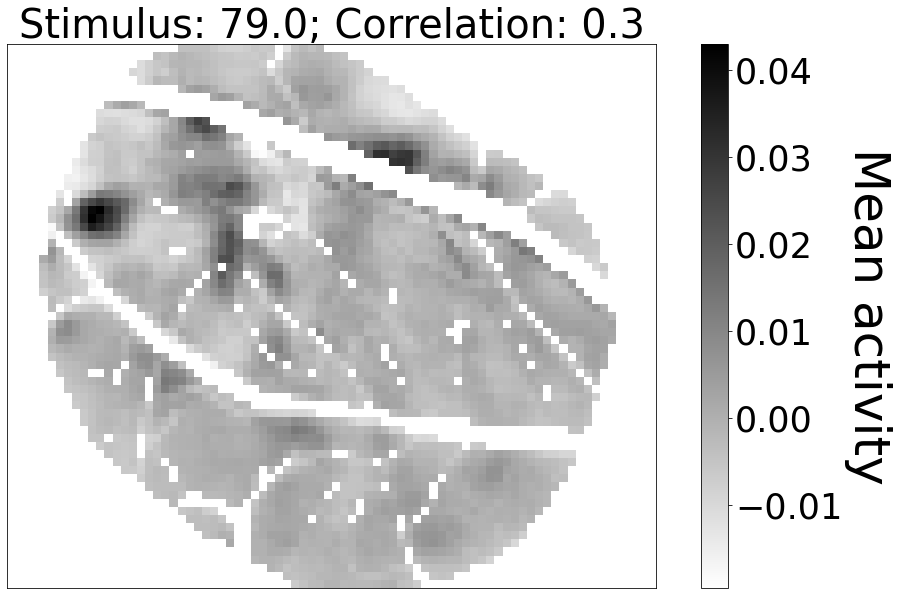

87.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82043.47it/s]


(2, 5360) (5360,)


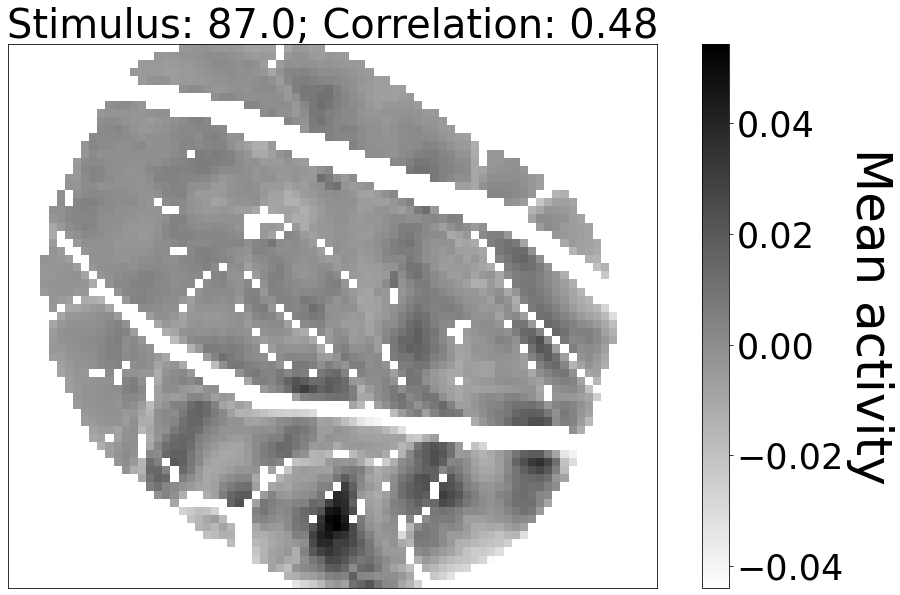

90.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 78989.89it/s]


(2, 5360) (5360,)


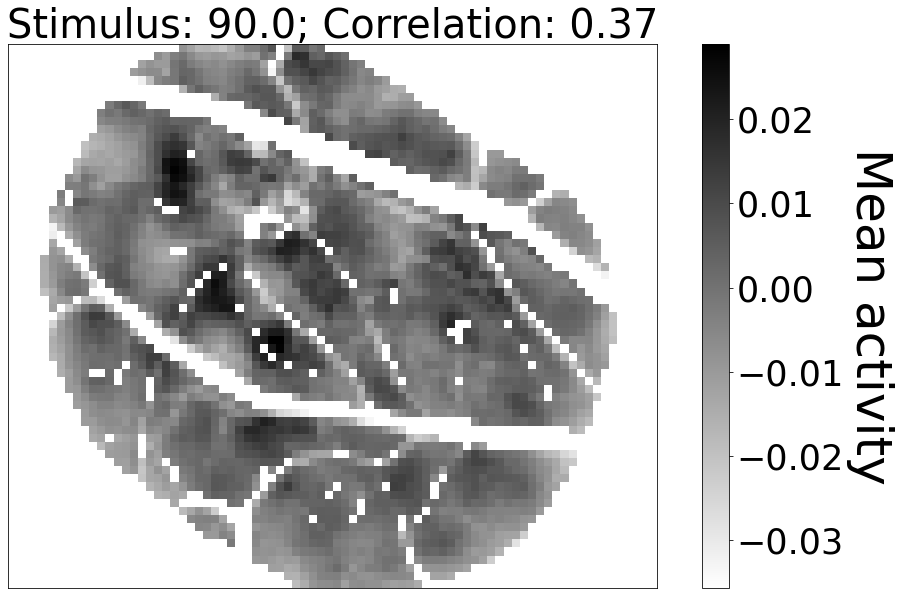

95.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 79032.65it/s]


(2, 5360) (5360,)


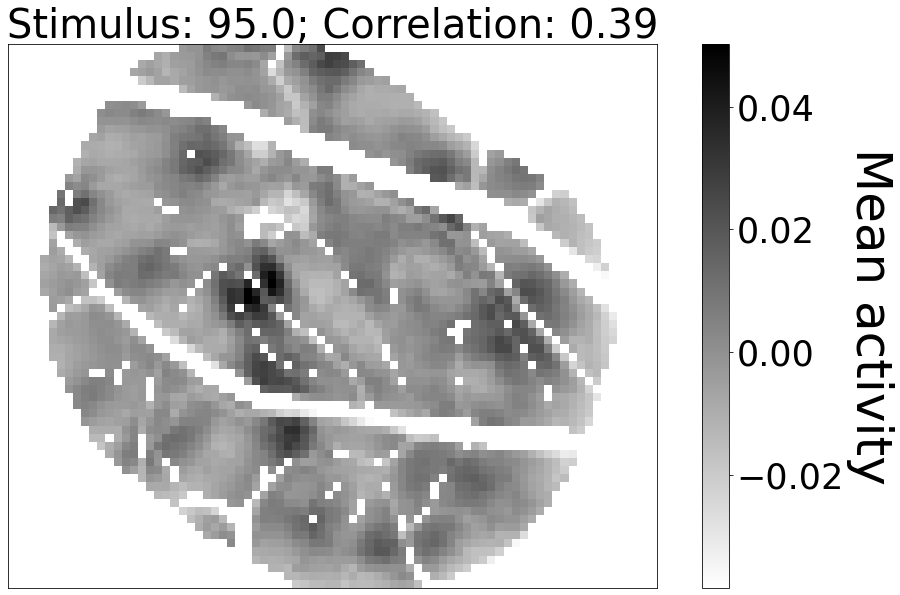

98.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82638.79it/s]


(2, 5360) (5360,)


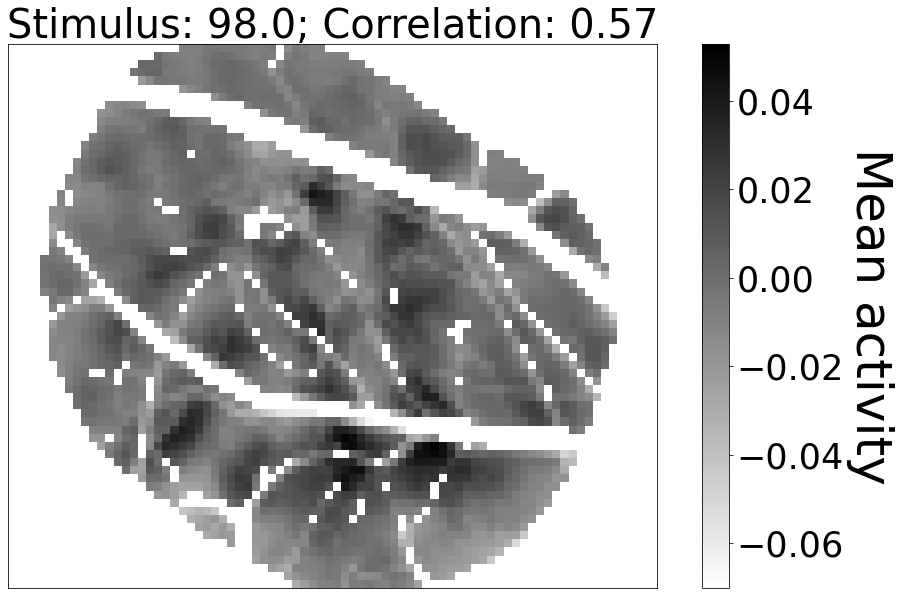

99.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82147.50it/s]


(2, 5360) (5360,)


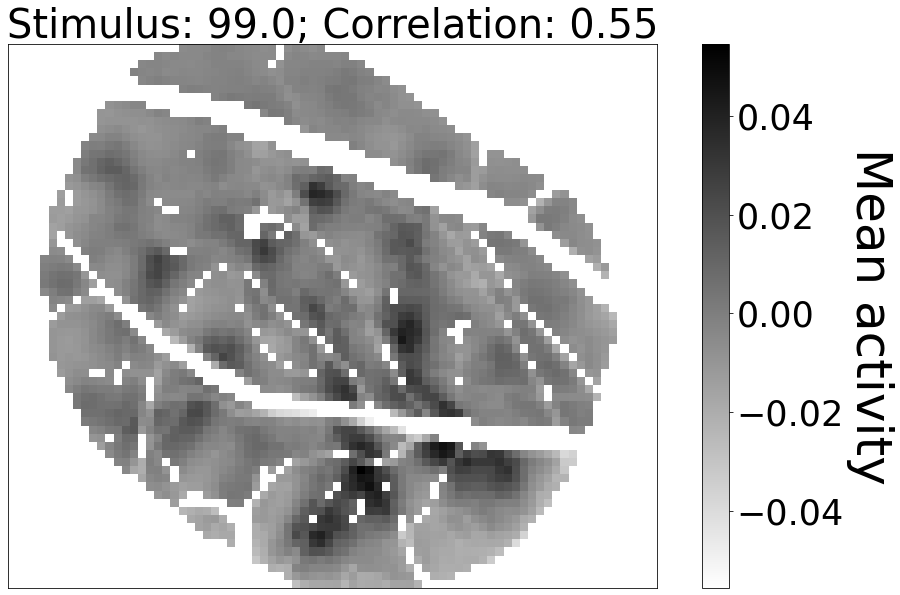

101.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82683.16it/s]


(2, 5360) (5360,)


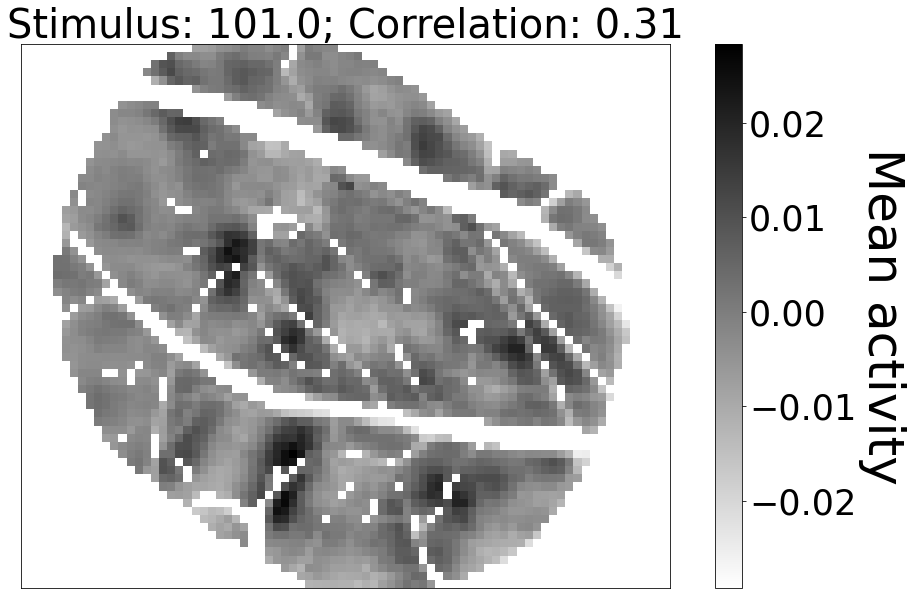

102.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 74657.52it/s]


(2, 5360) (5360,)


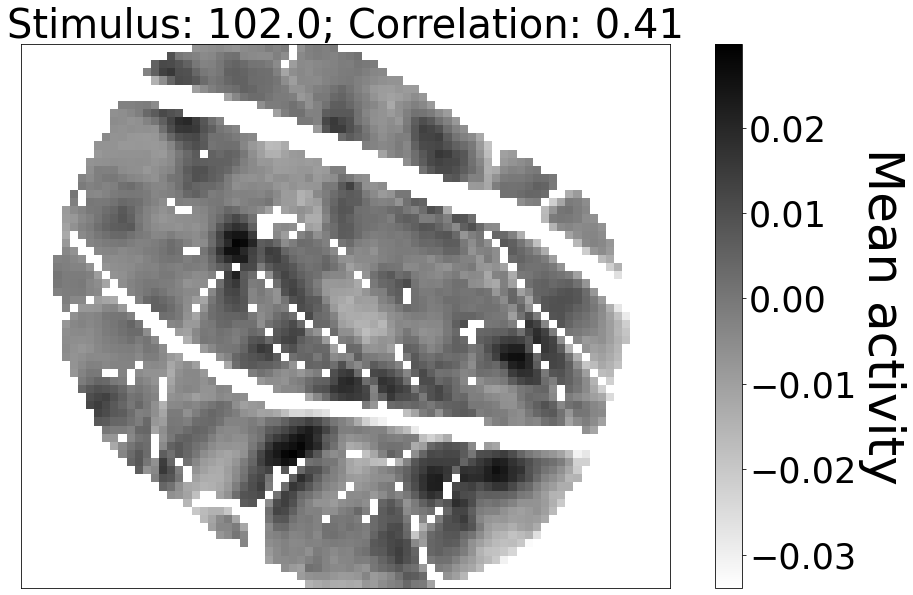

104.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82650.03it/s]


(2, 5360) (5360,)


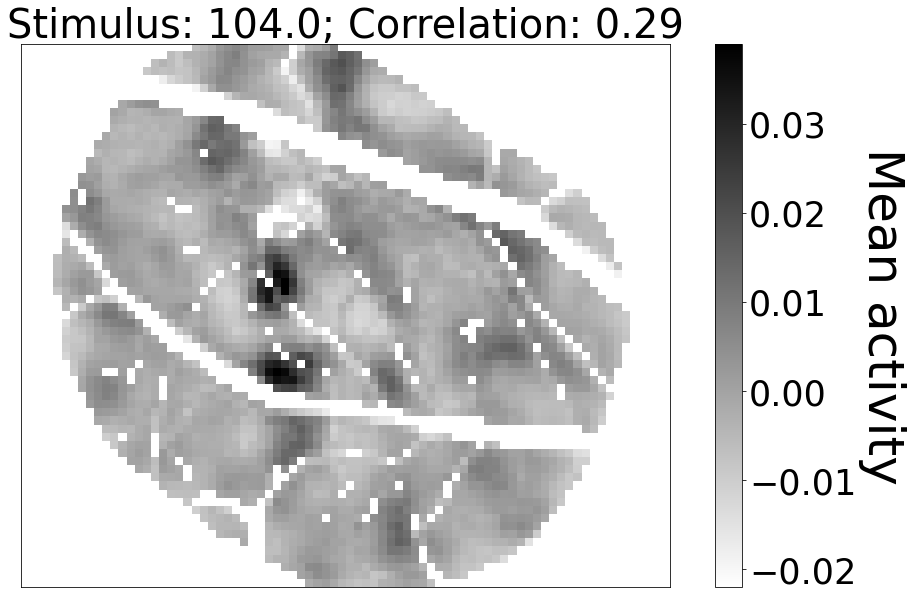

107.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 81396.50it/s]


(2, 5360) (5360,)


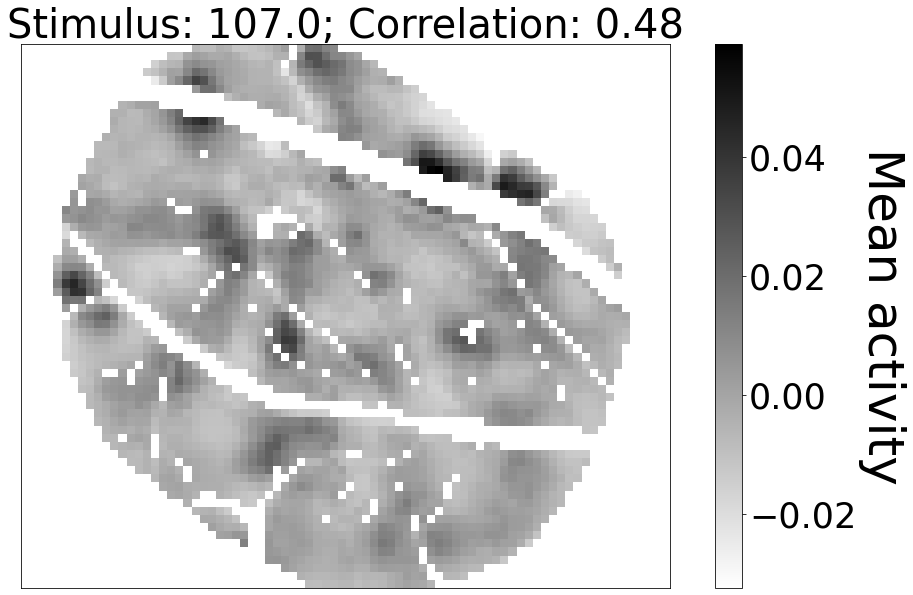

108.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82684.38it/s]


(2, 5360) (5360,)


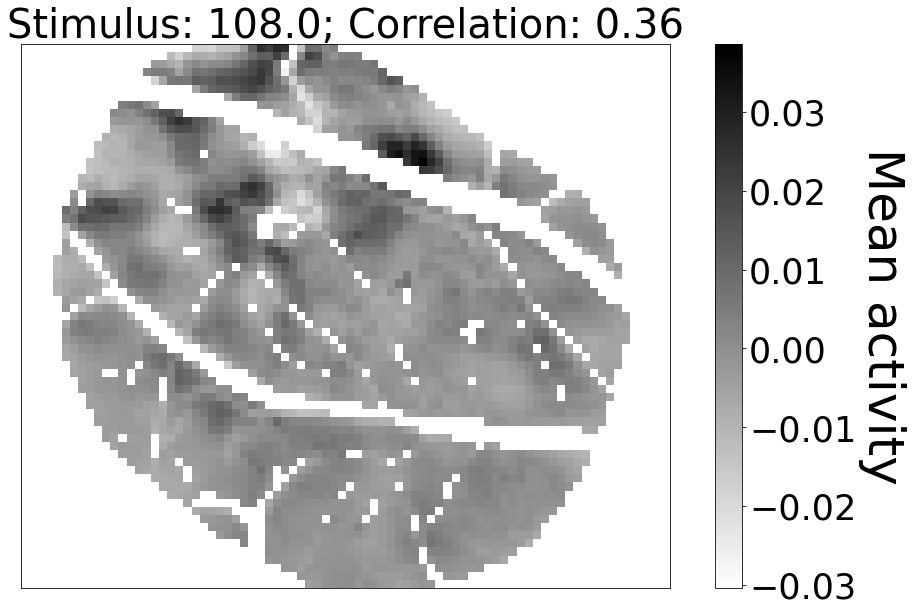

117.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 82679.21it/s]


(2, 5360) (5360,)


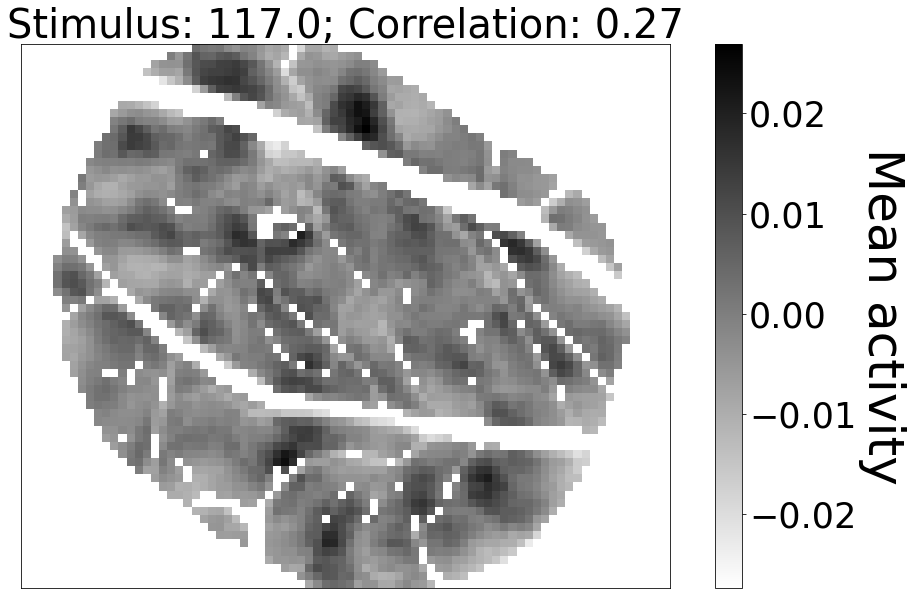

119.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 81999.78it/s]


(2, 5360) (5360,)


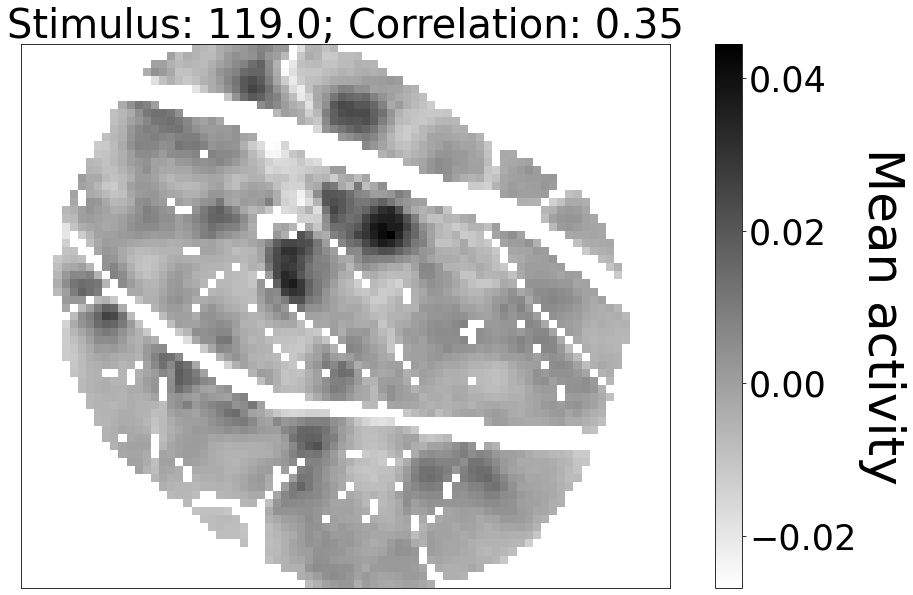

123.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 76737.99it/s]


(2, 5360) (5360,)


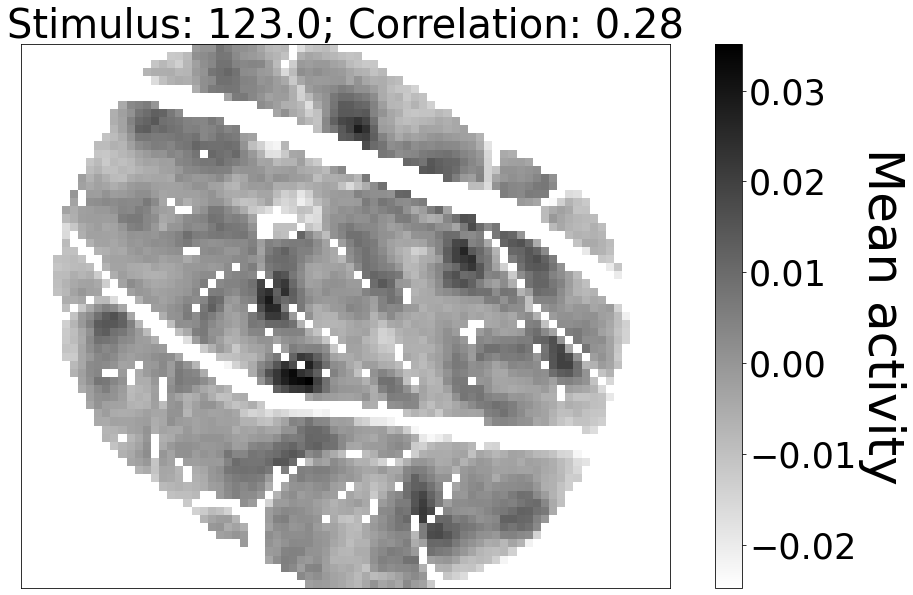

126.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 76760.53it/s]


(2, 5360) (5360,)


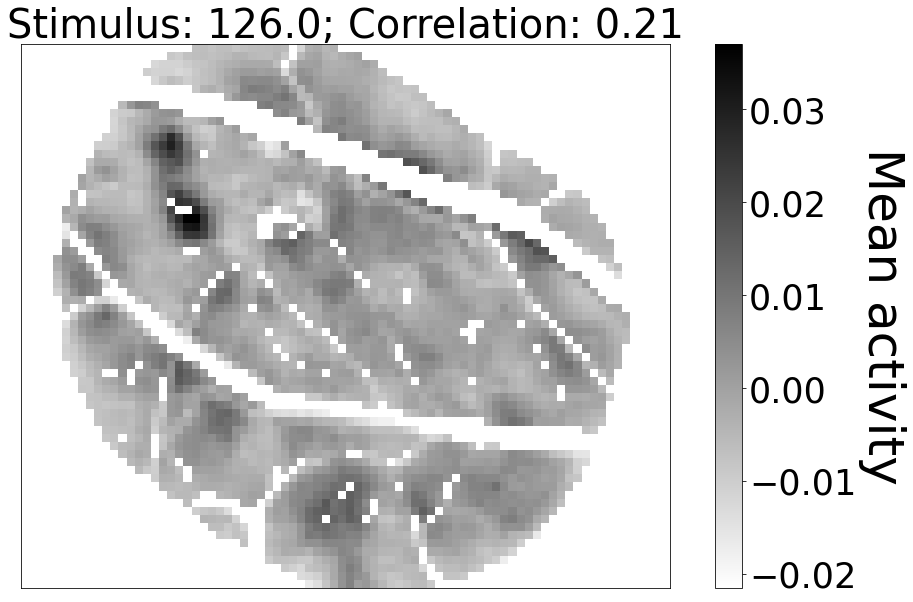

129.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 84008.02it/s]


(2, 5360) (5360,)


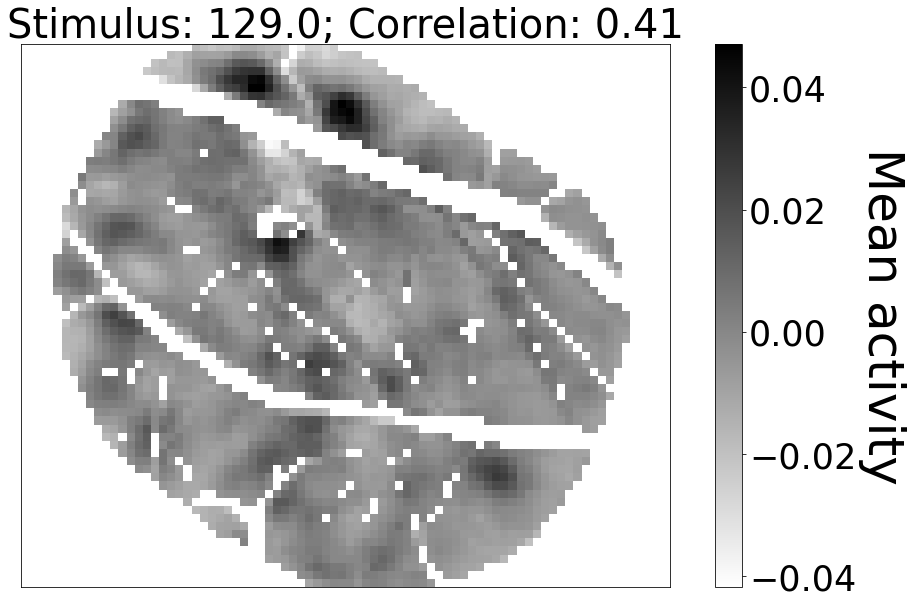

130.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 80107.29it/s]


(2, 5360) (5360,)


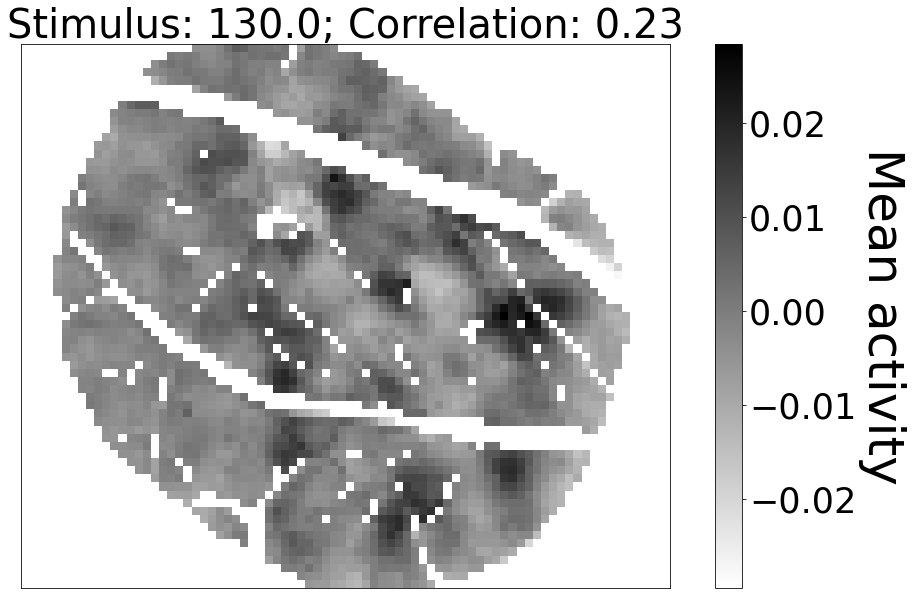

131.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 85193.87it/s]


(2, 5360) (5360,)


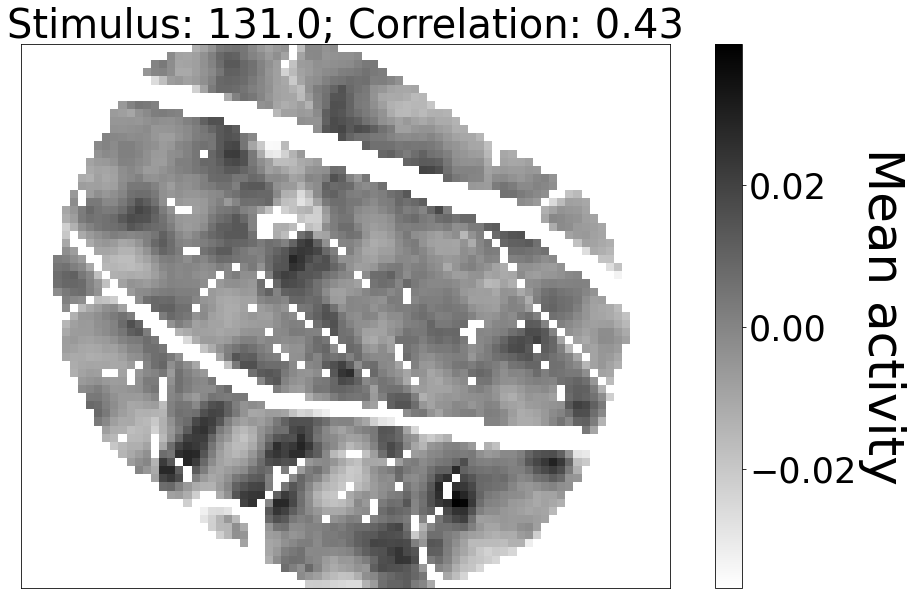

137.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 85215.18it/s]


(2, 5360) (5360,)


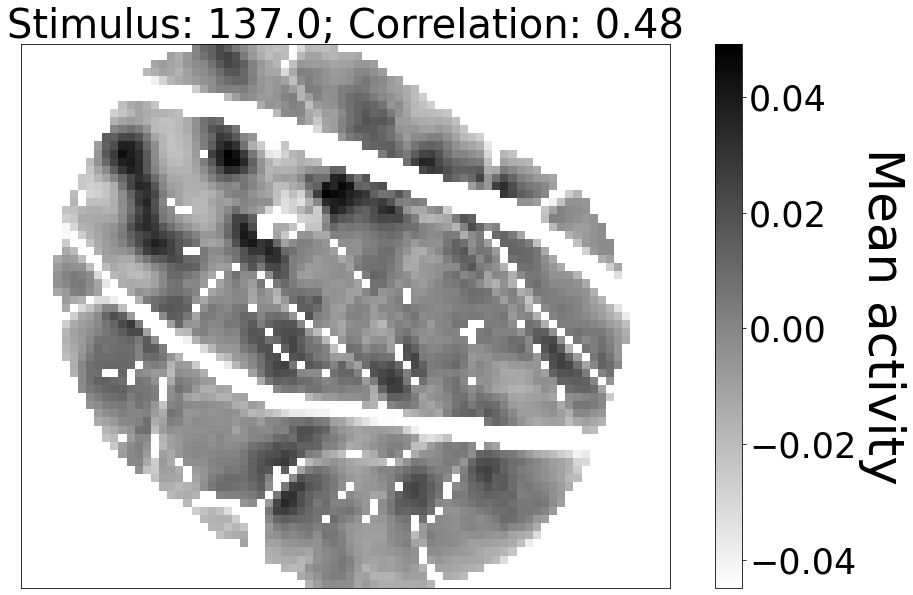

139.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 80253.99it/s]


(2, 5360) (5360,)


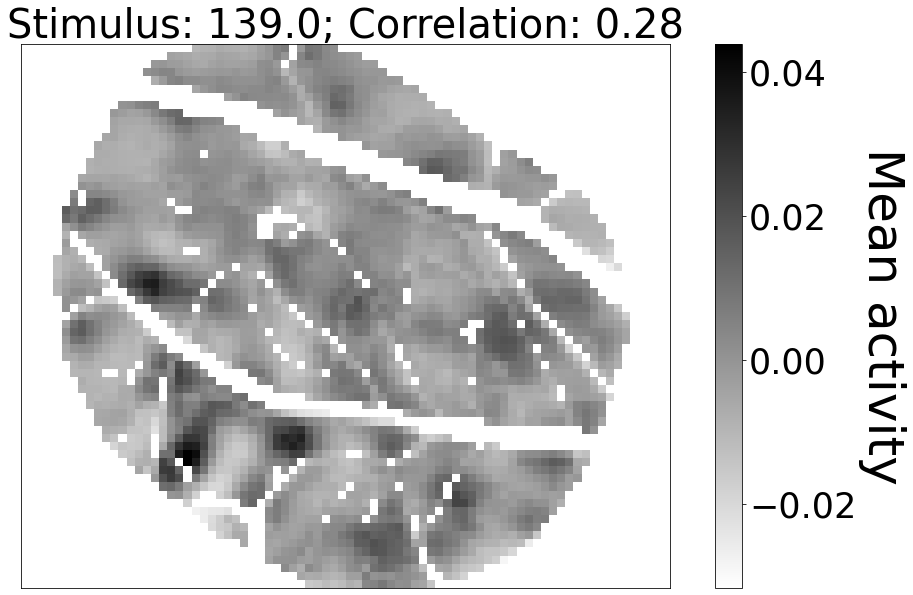

142.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 77316.49it/s]


(2, 5360) (5360,)


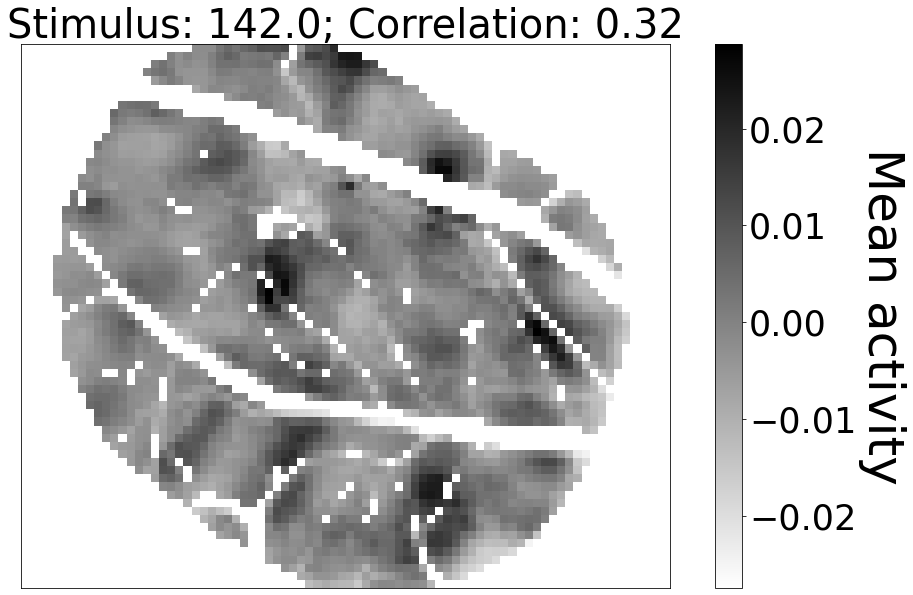

157.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 74392.44it/s]


(2, 5360) (5360,)


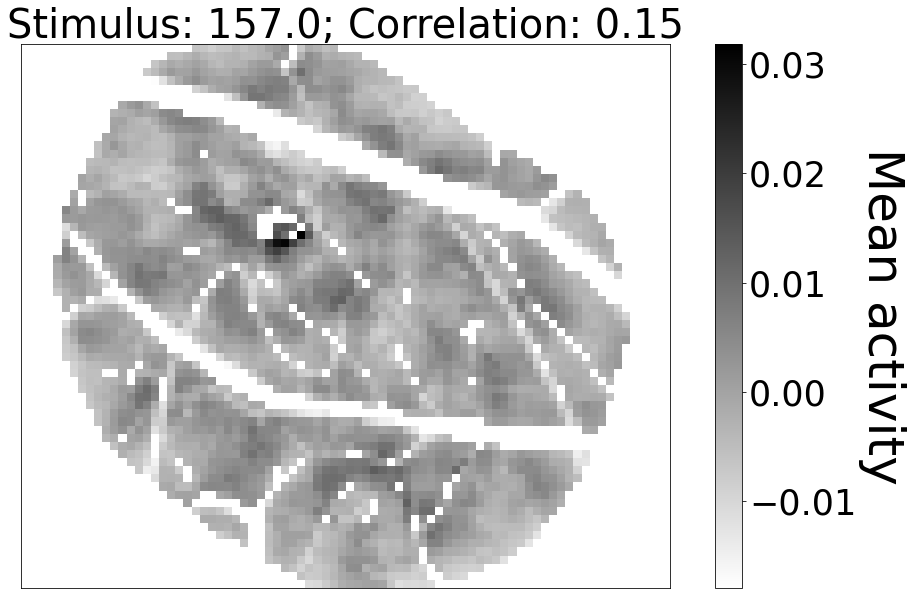

158.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 78993.77it/s]


(2, 5360) (5360,)


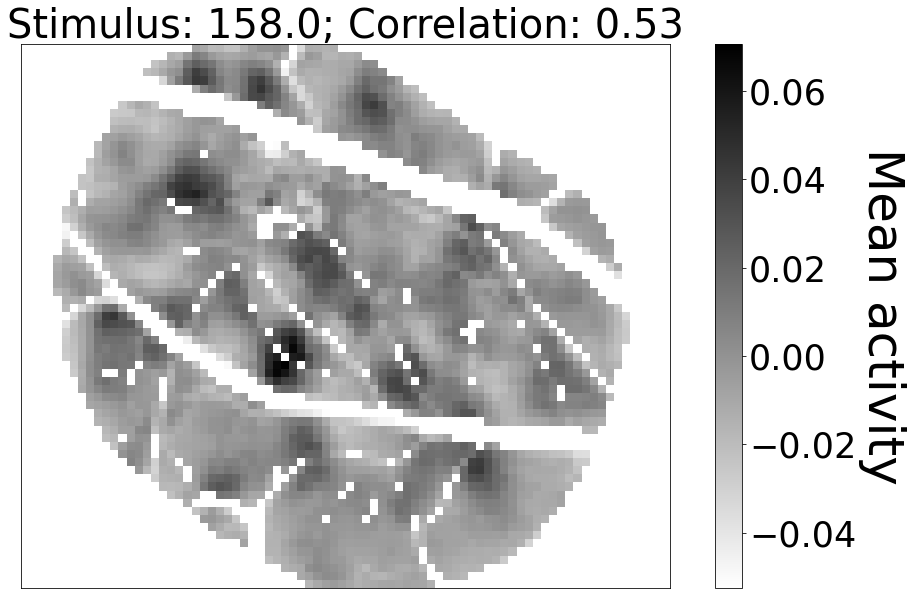

161.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 63234.92it/s]


(2, 5360) (5360,)


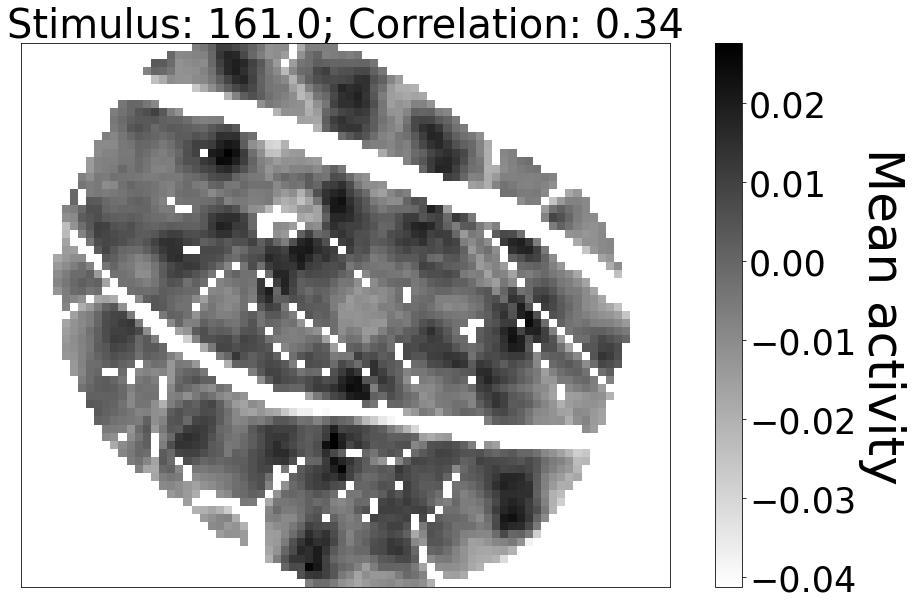

169.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 80215.33it/s]


(2, 5360) (5360,)


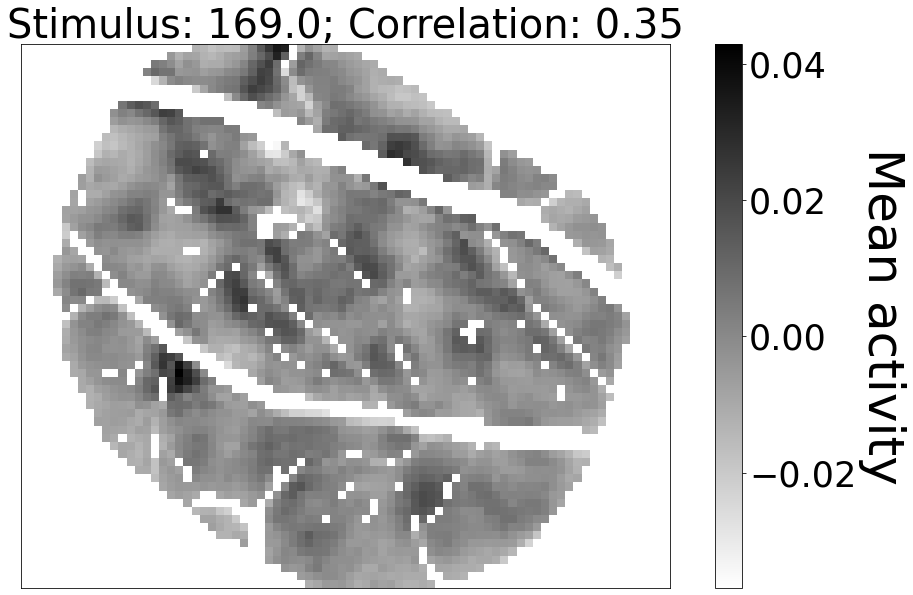

179.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 61750.91it/s]


(2, 5360) (5360,)


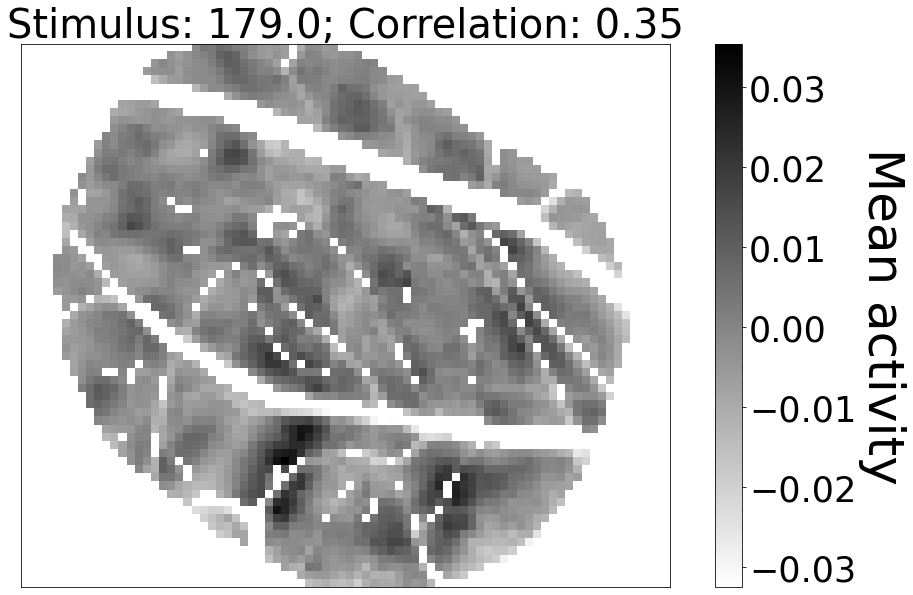

180.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83977.58it/s]


(2, 5360) (5360,)


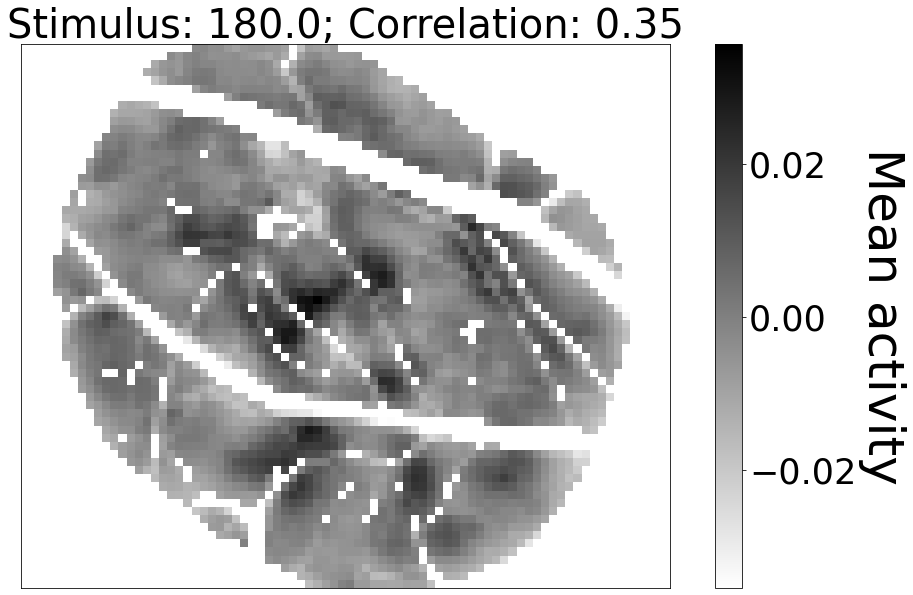

181.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83965.97it/s]


(2, 5360) (5360,)


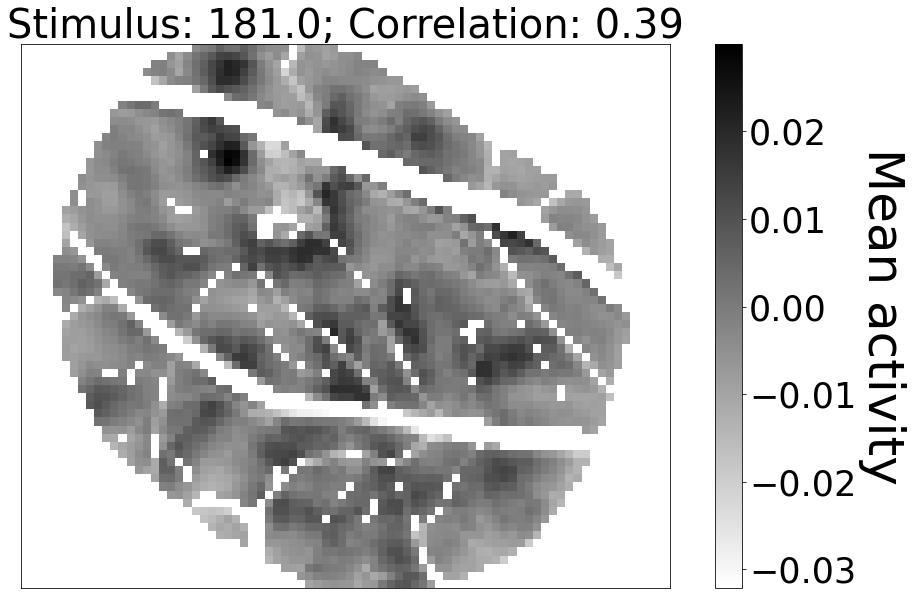

182.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 74620.10it/s]


(2, 5360) (5360,)


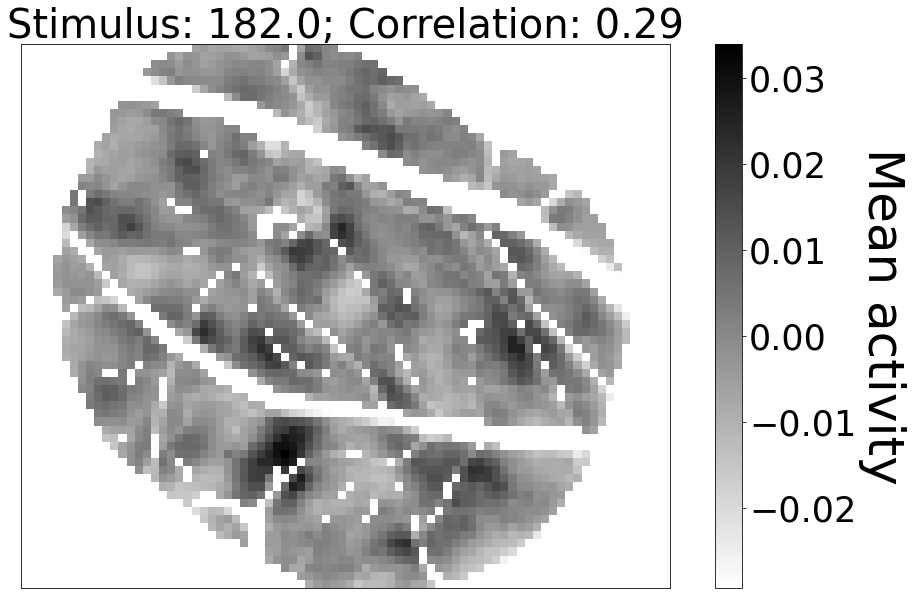

188.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 83925.85it/s]


(2, 5360) (5360,)


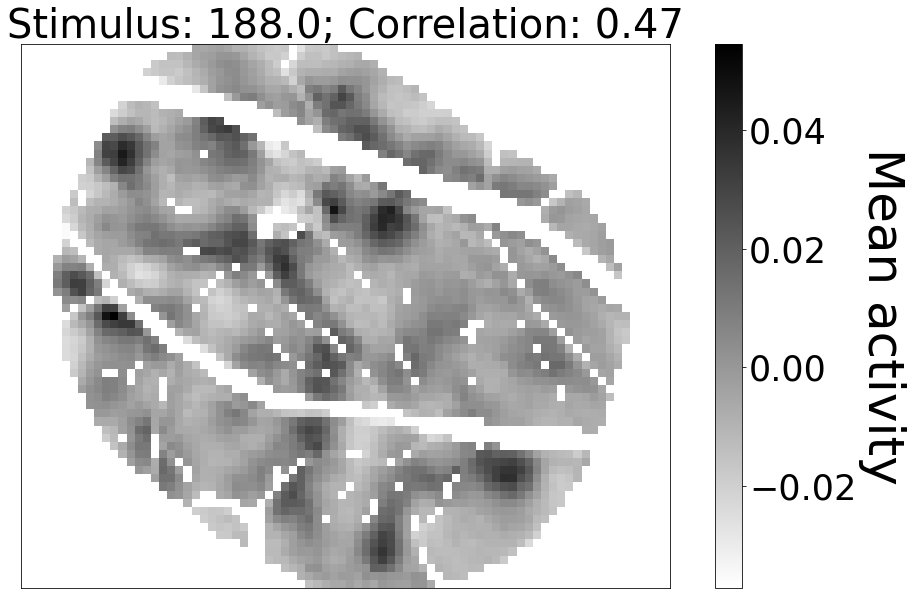

191.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 81431.59it/s]


(2, 5360) (5360,)


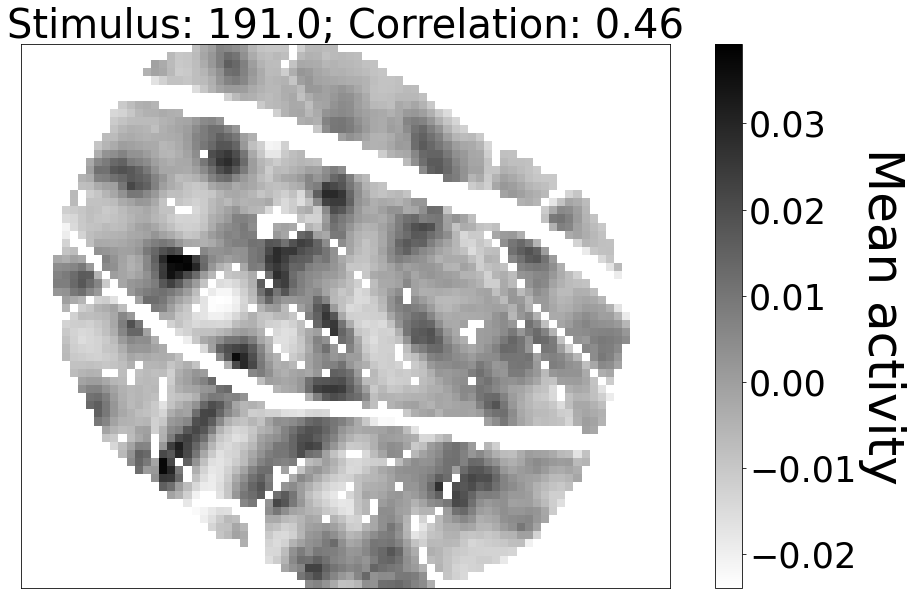

192.0


100%|███████████████████████████████████████████████████████████████████████████| 5360/5360 [00:00<00:00, 69761.03it/s]


(2, 5360) (5360,)


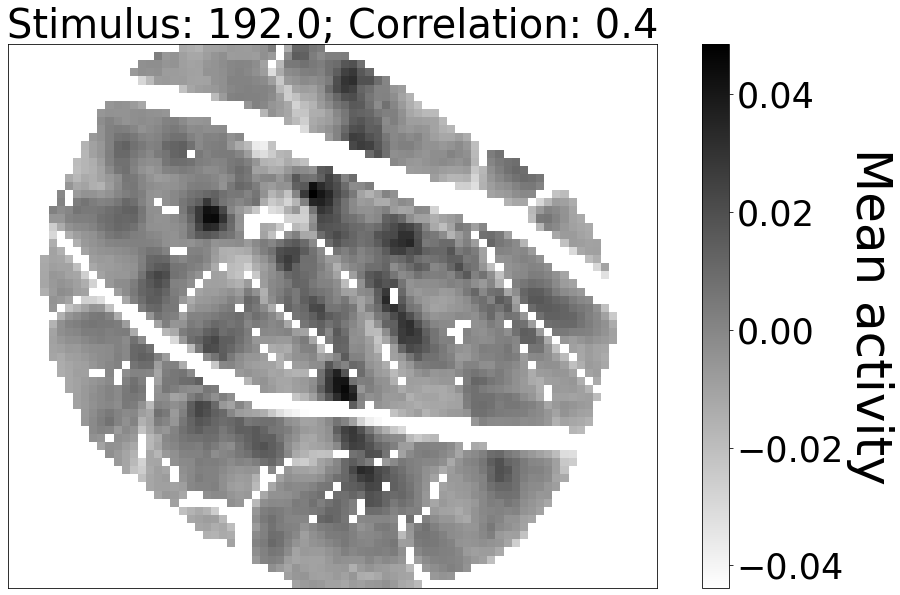

In [12]:
corr, stims, trial_means = trial_correlate_2("complex_sub", None, single_input=False)

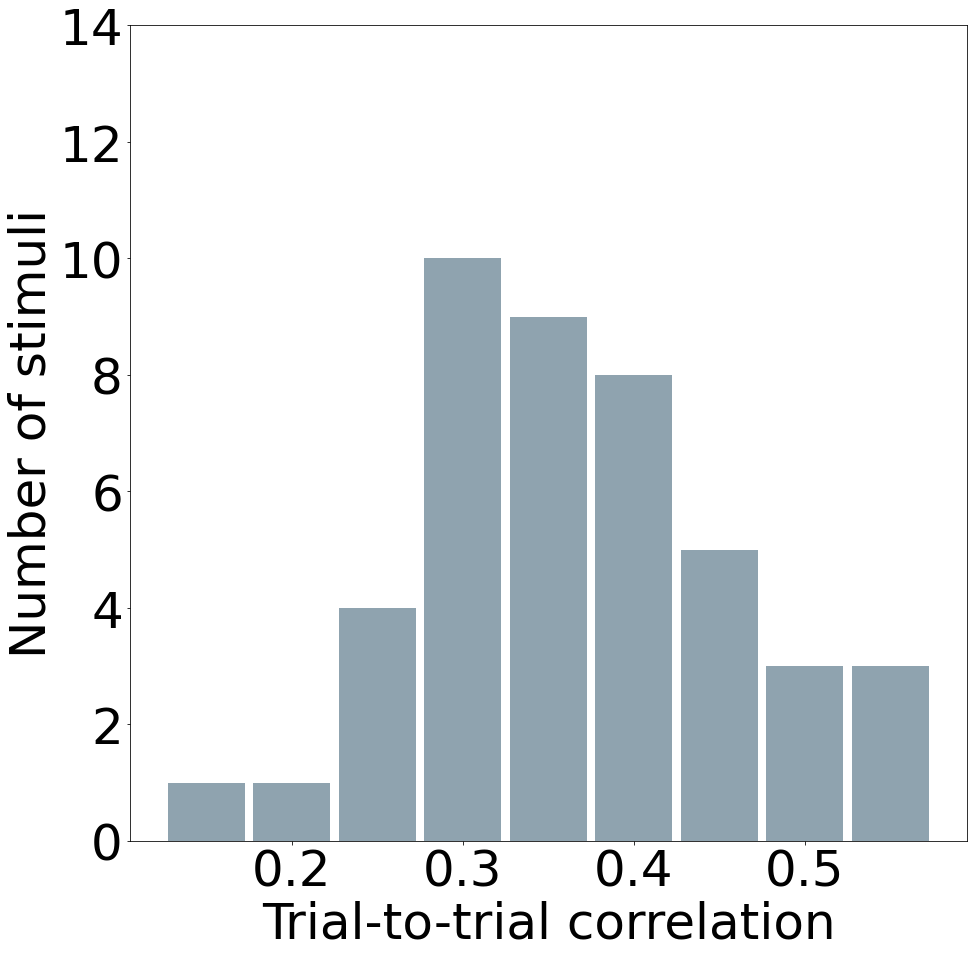

In [8]:
# Histogram of ttt correlations
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.hist(corr, bins=np.arange(0.15,0.65,0.05)-0.025, color='#607c8e', alpha=0.7,  rwidth=0.9)
ax.set_ylim([0,14])                     
ax.set_xlabel("Trial-to-trial correlation", fontsize=50)
ax.set_ylabel("Number of stimuli", fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.show()
fig.savefig("Document Plots/ttt_correlations_8trials.png")